## Setup Environment

In [1]:
# Install specific libraries
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 20.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.8 MB/s e

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set Working Directory
%cd /content/drive/MyDrive/CSE6242


/content/drive/MyDrive/Project11_FakeNewsDetection


## Load Dataset

In [5]:
# Load and prepare the dataset
df = pd.read_csv("combined_reviews.csv")
df['reviewContent'] = df['reviewContent'].fillna('').astype(str)  # Handle missing data
df

,reviewContent,label
0,We ate at Glenn's Diner over the weekend and s...,0
1,This place was great! We came on a Friday nigh...,1
2,"There was potential here, but it was too short...",1
3,My mom has been a fan of this quaint place for...,1
4,"Cat loves it, acts like a suction cup and has...",1
...,...,...
56812,"First, I'm not a vegan or a veggie. But my fat...",0
56813,"This is a very nice little set, and very comfo...",1
56814,I was totally disappointed in this restaurant ...,0
56815,Love this place. Great food. Dining in service...,1


([<matplotlib.patches.Wedge at 0x79a4e5618b80>,
 [Text(-1.1999784056221885, -0.0071990305202076915, 'Fake'),
  Text(1.1999784062962051, 0.007198918170120909, 'True')],
 [Text(-0.6999874032796098, -0.004199434470121153, '50.2%'),
  Text(0.6999874036727862, 0.00419936893257053, '49.8%')])

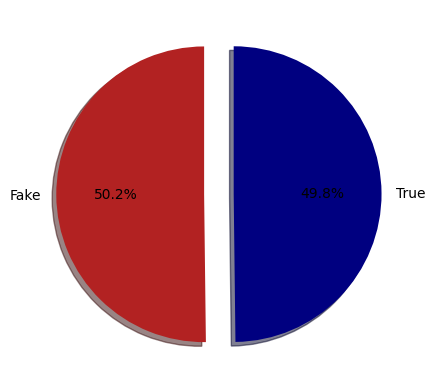

In [6]:
# Checking if our data is well balanced
label_size = [df['label'].sum(),len(df['label'])-df['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [7]:
# Train-Validation-Test split
train_text, temp_text, train_labels, temp_labels = train_test_split(
    df['reviewContent'], df['label'],
    random_state=2018,
    test_size=0.3,
    stratify=df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    random_state=2018,
    test_size=0.5,
    stratify=temp_labels
)

## BERT Fine-tuning

### Load pretrained BERT Model

In [8]:
# Load BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-large-uncased')
# tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')
# from transformers import RobertaModel, RobertaTokenizerFast
# bert = RobertaModel.from_pretrained('roberta-base')
# tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Freeze BERT layers
for param in bert.parameters():
    param.requires_grad = False

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

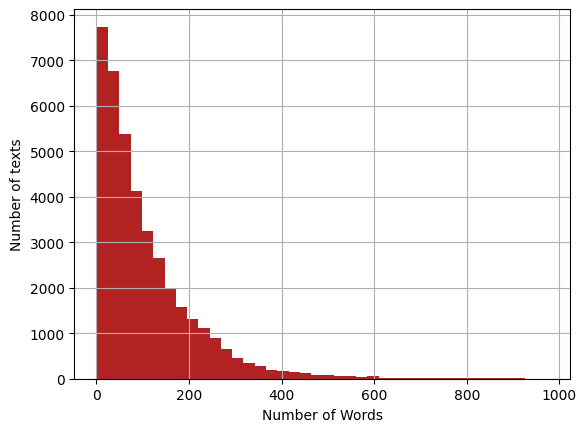

In [9]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(reviewContent.split()) for reviewContent in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [10]:
# Filter the DataFrame for reviews with very low word counts
low_word_reviews = df[df['reviewContent'].str.split().apply(len) <= 5]

# Examine the reviews
print(low_word_reviews['reviewContent'])


75                    best falafel ever!
81           this pizza kills. so yummy!
141         Great cubano and  Vieja Roja
220      short and simple.goooood sushi.
388         It's better than Tecalitlan!
                      ...               
56325         Foods ok.  Way overpriced.
56483                           Amazing.
56532                         sooo good!
56554                       MEH, It's OK
56638      best sushi place in downtown!
Name: reviewContent, Length: 416, dtype: object


In [11]:
# Tokenization and encoding
MAX_LENGTH = 50
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'  # Return PyTorch tensors
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [12]:
# Convert to tensors
train_seq = tokens_train['input_ids']
train_mask = tokens_train['attention_mask']
train_y = torch.tensor(train_labels.tolist())

val_seq = tokens_val['input_ids']
val_mask = tokens_val['attention_mask']
val_y = torch.tensor(val_labels.tolist())

test_seq = tokens_test['input_ids']
test_mask = tokens_test['attention_mask']
test_y = torch.tensor(test_labels.tolist())

In [13]:
# DataLoader
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

### Define Model Architecture

In [14]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
model.to(device)

# Optimizer and loss function
from torch.optim import AdamW
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5  # Learning rate
)
cross_entropy = nn.NLLLoss()

### Define Train & Evaluate & Test Function

In [15]:
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Move batch to the same device as model
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Optional: Print progress updates
        if step % 50 == 0 and step != 0:
            print(f'Batch {step:>5} of {len(train_dataloader)}')

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


def evaluate():
    model.eval()
    total_loss = 0
    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

        # Optional: Print progress updates
        if step % 50 == 0 and step != 0:
            print(f'Validation Batch {step:>5} of {len(val_dataloader)}')

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

# Function to Evaluate Model on Test Data in Batches
def evaluate_test(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for step, batch in enumerate(dataloader):
            batch = [t.to(device) for t in batch]
            sent_id, mask, labels = batch

            preds = model(sent_id, mask)
            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels



### Model training

In [19]:
# Model training
epochs = 50
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_new.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 50
Batch    50 of 1243
Batch   100 of 1243
Batch   150 of 1243
Batch   200 of 1243
Batch   250 of 1243
Batch   300 of 1243
Batch   350 of 1243
Batch   400 of 1243
Batch   450 of 1243
Batch   500 of 1243
Batch   550 of 1243
Batch   600 of 1243
Batch   650 of 1243
Batch   700 of 1243
Batch   750 of 1243
Batch   800 of 1243
Batch   850 of 1243
Batch   900 of 1243
Batch   950 of 1243
Batch  1000 of 1243
Batch  1050 of 1243
Batch  1100 of 1243
Batch  1150 of 1243
Batch  1200 of 1243
Validation Batch    50 of 267
Validation Batch   100 of 267
Validation Batch   150 of 267
Validation Batch   200 of 267
Validation Batch   250 of 267

Training Loss: 0.377
Validation Loss: 0.362

 Epoch 2 / 50
Batch    50 of 1243
Batch   100 of 1243
Batch   150 of 1243
Batch   200 of 1243
Batch   250 of 1243
Batch   300 of 1243
Batch   350 of 1243
Batch   400 of 1243
Batch   450 of 1243
Batch   500 of 1243
Batch   550 of 1243
Batch   600 of 1243
Batch   650 of 1243
Batch   700 of 1243
Batch   750 of 

### Model performance

In [20]:
model_test = BERT_Arch(bert)
model_test.load_state_dict(torch.load('saved_weights_new.pt'))
model_test.to(device)  # Make sure to move the model to the same device (GPU/CPU) as the test data


BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [21]:
# Evaluate the model
true_labels, predictions = evaluate_test(model_test, test_dataloader)

# Print classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.98      0.77      0.86      5405
           1       0.71      0.97      0.82      3118

    accuracy                           0.84      8523
   macro avg       0.85      0.87      0.84      8523
weighted avg       0.88      0.84      0.85      8523



## Fake News Predictions

In [22]:
from tqdm import tqdm

In [1]:
import time
import os as os

In [24]:
# Read CSV file
model_test.to(device)
df = pd.read_csv("updated_filtered_atlanta_restaurant_reviews.csv")
# Define a function to predict label
def predict_label(text):
    if pd.isna(text) or not isinstance(text, str):  # Check for non-text cells
        return 0  # Mark as real if it's not text
    tokens = tokenizer.encode_plus(
        text,
        max_length=MAX_LENGTH,
        padding='max_length',  # Updated padding argument
        truncation=True,
        return_tensors="pt"
    )
    seq = tokens['input_ids'].to(device)
    mask = tokens['attention_mask'].to(device)

    with torch.no_grad():
        preds = model_test(seq, mask)
        preds = preds[0] if isinstance(preds, tuple) else preds
    return np.argmax(preds.cpu().numpy(), axis=1)[0]

# Split dataframe into chunks
chunk_size = 1000
chunks = np.array_split(df, len(df) // chunk_size)

# # Create 'data' directory if it doesn't exist
data_directory = "data_new_combined"
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

# # List to hold processed chunks for final file
processed_chunks = []

# Process each chunk and save
for i, chunk in enumerate(tqdm(chunks, desc="Processing Chunks"), start=1):
    processed_chunk = chunk.copy()
    processed_chunk['predicted_label'] = processed_chunk['text'].apply(predict_label)

    # Generate a filename using only the chunk number
    filename = os.path.join(data_directory, f"{i}.csv")

    # Save processed chunk to CSV in the 'data' directory
    processed_chunk.to_csv(filename, index=False)

    # Append the processed chunk to the list
    processed_chunks.append(processed_chunk)

    print(f"Chunk {i} saved as {filename}")

# Concatenate all processed chunks
final_df = pd.concat(processed_chunks)

# Save the final complete file
final_filename = os.path.join(data_directory, "complete_file.csv")
final_df.to_csv(final_filename, index=False)

print(f"Final complete file saved as {final_filename}")

# # Split dataframe into chunks
# chunk_size = 1000
# chunks = np.array_split(df, len(df) // chunk_size)

# # Ensure 'data' directory exists
# data_directory = "data_new"
# if not os.path.exists(data_directory):
#     os.makedirs(data_directory)

# # List to hold newly processed chunks
# processed_chunks = []

# # Start processing from chunk 407 (index 406)
# start_chunk_index = 406
# for i, chunk in enumerate(tqdm(chunks[start_chunk_index:], desc="Processing Chunks"), start=start_chunk_index + 1):
#     processed_chunk = chunk.copy()
#     processed_chunk['predicted_label'] = processed_chunk['text'].apply(predict_label)

#     filename = os.path.join(data_directory, f"{i}.csv")
#     if not os.path.exists(filename):
#         processed_chunk.to_csv(filename, index=False)
#         print(f"Chunk {i} saved as {filename}")
#         processed_chunks.append(processed_chunk)
#     else:
#         print(f"Chunk {i} already processed. Skipping.")

# # Concatenate all newly processed chunks with previously processed ones
# new_processed_chunks = pd.concat(processed_chunks)
# existing_processed_chunks = pd.concat([pd.read_csv(os.path.join(data_directory, f"{j}.csv")) for j in range(1, start_chunk_index + 1)])
# final_df = pd.concat([existing_processed_chunks, new_processed_chunks])

# # Save the final complete file
# final_filename = os.path.join(data_directory, "complete_file.csv")
# final_df.to_csv(final_filename, index=False)

# print(f"Final complete file saved as {final_filename}")

Processing Chunks:   0%|          | 1/760 [00:11<2:19:44, 11.05s/it]

Chunk 1 saved as data_new_combined/1.csv


Processing Chunks:   0%|          | 2/760 [00:21<2:14:28, 10.64s/it]

Chunk 2 saved as data_new_combined/2.csv


Processing Chunks:   0%|          | 3/760 [00:32<2:15:08, 10.71s/it]

Chunk 3 saved as data_new_combined/3.csv


Processing Chunks:   1%|          | 4/760 [00:40<2:03:24,  9.79s/it]

Chunk 4 saved as data_new_combined/4.csv


Processing Chunks:   1%|          | 5/760 [00:51<2:08:17, 10.20s/it]

Chunk 5 saved as data_new_combined/5.csv


Processing Chunks:   1%|          | 6/760 [01:00<2:04:48,  9.93s/it]

Chunk 6 saved as data_new_combined/6.csv


Processing Chunks:   1%|          | 7/760 [01:08<1:56:46,  9.30s/it]

Chunk 7 saved as data_new_combined/7.csv


Processing Chunks:   1%|          | 8/760 [01:15<1:46:28,  8.50s/it]

Chunk 8 saved as data_new_combined/8.csv


Processing Chunks:   1%|          | 9/760 [01:22<1:40:00,  7.99s/it]

Chunk 9 saved as data_new_combined/9.csv


Processing Chunks:   1%|▏         | 10/760 [01:30<1:38:10,  7.85s/it]

Chunk 10 saved as data_new_combined/10.csv


Processing Chunks:   1%|▏         | 11/760 [01:43<2:00:32,  9.66s/it]

Chunk 11 saved as data_new_combined/11.csv


Processing Chunks:   2%|▏         | 12/760 [01:47<1:37:44,  7.84s/it]

Chunk 12 saved as data_new_combined/12.csv


Processing Chunks:   2%|▏         | 13/760 [01:56<1:42:08,  8.20s/it]

Chunk 13 saved as data_new_combined/13.csv


Processing Chunks:   2%|▏         | 14/760 [02:10<2:03:30,  9.93s/it]

Chunk 14 saved as data_new_combined/14.csv


Processing Chunks:   2%|▏         | 15/760 [02:17<1:52:52,  9.09s/it]

Chunk 15 saved as data_new_combined/15.csv


Processing Chunks:   2%|▏         | 16/760 [02:24<1:46:02,  8.55s/it]

Chunk 16 saved as data_new_combined/16.csv


Processing Chunks:   2%|▏         | 17/760 [02:29<1:32:15,  7.45s/it]

Chunk 17 saved as data_new_combined/17.csv


Processing Chunks:   2%|▏         | 18/760 [02:38<1:37:45,  7.91s/it]

Chunk 18 saved as data_new_combined/18.csv


Processing Chunks:   2%|▎         | 19/760 [02:52<1:57:48,  9.54s/it]

Chunk 19 saved as data_new_combined/19.csv


Processing Chunks:   3%|▎         | 20/760 [02:52<1:23:06,  6.74s/it]

Chunk 20 saved as data_new_combined/20.csv


Processing Chunks:   3%|▎         | 21/760 [03:06<1:49:33,  8.90s/it]

Chunk 21 saved as data_new_combined/21.csv


Processing Chunks:   3%|▎         | 22/760 [03:20<2:07:33, 10.37s/it]

Chunk 22 saved as data_new_combined/22.csv


Processing Chunks:   3%|▎         | 23/760 [03:25<1:48:02,  8.80s/it]

Chunk 23 saved as data_new_combined/23.csv
Chunk 24 saved as data_new_combined/24.csv


Processing Chunks:   3%|▎         | 25/760 [03:37<1:31:47,  7.49s/it]

Chunk 25 saved as data_new_combined/25.csv


Processing Chunks:   3%|▎         | 26/760 [03:43<1:28:10,  7.21s/it]

Chunk 26 saved as data_new_combined/26.csv


Processing Chunks:   4%|▎         | 27/760 [03:45<1:10:49,  5.80s/it]

Chunk 27 saved as data_new_combined/27.csv


Processing Chunks:   4%|▎         | 28/760 [03:59<1:37:23,  7.98s/it]

Chunk 28 saved as data_new_combined/28.csv


Processing Chunks:   4%|▍         | 29/760 [04:01<1:16:54,  6.31s/it]

Chunk 29 saved as data_new_combined/29.csv


Processing Chunks:   4%|▍         | 30/760 [04:11<1:31:03,  7.48s/it]

Chunk 30 saved as data_new_combined/30.csv


Processing Chunks:   4%|▍         | 31/760 [04:17<1:24:33,  6.96s/it]

Chunk 31 saved as data_new_combined/31.csv


Processing Chunks:   4%|▍         | 32/760 [04:27<1:35:15,  7.85s/it]

Chunk 32 saved as data_new_combined/32.csv


Processing Chunks:   4%|▍         | 33/760 [04:33<1:28:45,  7.33s/it]

Chunk 33 saved as data_new_combined/33.csv


Processing Chunks:   4%|▍         | 34/760 [04:46<1:49:53,  9.08s/it]

Chunk 34 saved as data_new_combined/34.csv


Processing Chunks:   5%|▍         | 35/760 [04:57<1:56:13,  9.62s/it]

Chunk 35 saved as data_new_combined/35.csv
Chunk 36 saved as data_new_combined/36.csv


Processing Chunks:   5%|▍         | 37/760 [05:06<1:28:30,  7.34s/it]

Chunk 37 saved as data_new_combined/37.csv


Processing Chunks:   5%|▌         | 38/760 [05:19<1:45:41,  8.78s/it]

Chunk 38 saved as data_new_combined/38.csv


Processing Chunks:   5%|▌         | 39/760 [05:33<2:00:09, 10.00s/it]

Chunk 39 saved as data_new_combined/39.csv
Chunk 40 saved as data_new_combined/40.csv


Processing Chunks:   5%|▌         | 41/760 [05:41<1:29:33,  7.47s/it]

Chunk 41 saved as data_new_combined/41.csv


Processing Chunks:   6%|▌         | 42/760 [05:55<1:46:53,  8.93s/it]

Chunk 42 saved as data_new_combined/42.csv


Processing Chunks:   6%|▌         | 43/760 [06:01<1:37:28,  8.16s/it]

Chunk 43 saved as data_new_combined/43.csv


Processing Chunks:   6%|▌         | 44/760 [06:02<1:17:23,  6.49s/it]

Chunk 44 saved as data_new_combined/44.csv


Processing Chunks:   6%|▌         | 45/760 [06:13<1:31:48,  7.70s/it]

Chunk 45 saved as data_new_combined/45.csv


Processing Chunks:   6%|▌         | 46/760 [06:25<1:44:21,  8.77s/it]

Chunk 46 saved as data_new_combined/46.csv


Processing Chunks:   6%|▌         | 47/760 [06:32<1:36:51,  8.15s/it]

Chunk 47 saved as data_new_combined/47.csv


Processing Chunks:   6%|▋         | 48/760 [06:37<1:28:35,  7.47s/it]

Chunk 48 saved as data_new_combined/48.csv


Processing Chunks:   6%|▋         | 49/760 [06:47<1:36:43,  8.16s/it]

Chunk 49 saved as data_new_combined/49.csv


Processing Chunks:   7%|▋         | 50/760 [06:56<1:37:25,  8.23s/it]

Chunk 50 saved as data_new_combined/50.csv


Processing Chunks:   7%|▋         | 51/760 [07:00<1:25:23,  7.23s/it]

Chunk 51 saved as data_new_combined/51.csv


Processing Chunks:   7%|▋         | 52/760 [07:09<1:29:52,  7.62s/it]

Chunk 52 saved as data_new_combined/52.csv


Processing Chunks:   7%|▋         | 53/760 [07:18<1:36:34,  8.20s/it]

Chunk 53 saved as data_new_combined/53.csv


Processing Chunks:   7%|▋         | 54/760 [07:28<1:40:57,  8.58s/it]

Chunk 54 saved as data_new_combined/54.csv


Processing Chunks:   7%|▋         | 55/760 [07:38<1:46:37,  9.07s/it]

Chunk 55 saved as data_new_combined/55.csv


Processing Chunks:   7%|▋         | 56/760 [07:47<1:47:14,  9.14s/it]

Chunk 56 saved as data_new_combined/56.csv


Processing Chunks:   8%|▊         | 57/760 [07:56<1:46:07,  9.06s/it]

Chunk 57 saved as data_new_combined/57.csv


Processing Chunks:   8%|▊         | 58/760 [08:07<1:52:28,  9.61s/it]

Chunk 58 saved as data_new_combined/58.csv


Processing Chunks:   8%|▊         | 59/760 [08:16<1:48:26,  9.28s/it]

Chunk 59 saved as data_new_combined/59.csv


Processing Chunks:   8%|▊         | 60/760 [08:25<1:48:07,  9.27s/it]

Chunk 60 saved as data_new_combined/60.csv


Processing Chunks:   8%|▊         | 61/760 [08:33<1:44:49,  9.00s/it]

Chunk 61 saved as data_new_combined/61.csv


Processing Chunks:   8%|▊         | 62/760 [08:42<1:41:58,  8.77s/it]

Chunk 62 saved as data_new_combined/62.csv


Processing Chunks:   8%|▊         | 63/760 [08:50<1:40:04,  8.62s/it]

Chunk 63 saved as data_new_combined/63.csv


Processing Chunks:   8%|▊         | 64/760 [08:59<1:41:45,  8.77s/it]

Chunk 64 saved as data_new_combined/64.csv


Processing Chunks:   9%|▊         | 65/760 [09:08<1:43:07,  8.90s/it]

Chunk 65 saved as data_new_combined/65.csv


Processing Chunks:   9%|▊         | 66/760 [09:17<1:43:01,  8.91s/it]

Chunk 66 saved as data_new_combined/66.csv


Processing Chunks:   9%|▉         | 67/760 [09:27<1:44:55,  9.08s/it]

Chunk 67 saved as data_new_combined/67.csv


Processing Chunks:   9%|▉         | 68/760 [09:36<1:44:50,  9.09s/it]

Chunk 68 saved as data_new_combined/68.csv


Processing Chunks:   9%|▉         | 69/760 [09:45<1:46:58,  9.29s/it]

Chunk 69 saved as data_new_combined/69.csv


Processing Chunks:   9%|▉         | 70/760 [09:55<1:48:46,  9.46s/it]

Chunk 70 saved as data_new_combined/70.csv


Processing Chunks:   9%|▉         | 71/760 [10:03<1:43:12,  8.99s/it]

Chunk 71 saved as data_new_combined/71.csv


Processing Chunks:   9%|▉         | 72/760 [10:13<1:44:16,  9.09s/it]

Chunk 72 saved as data_new_combined/72.csv


Processing Chunks:  10%|▉         | 73/760 [10:21<1:43:00,  9.00s/it]

Chunk 73 saved as data_new_combined/73.csv


Processing Chunks:  10%|▉         | 74/760 [10:30<1:42:44,  8.99s/it]

Chunk 74 saved as data_new_combined/74.csv


Processing Chunks:  10%|▉         | 75/760 [10:40<1:44:09,  9.12s/it]

Chunk 75 saved as data_new_combined/75.csv


Processing Chunks:  10%|█         | 76/760 [10:48<1:41:24,  8.90s/it]

Chunk 76 saved as data_new_combined/76.csv


Processing Chunks:  10%|█         | 77/760 [11:00<1:50:49,  9.74s/it]

Chunk 77 saved as data_new_combined/77.csv


Processing Chunks:  10%|█         | 78/760 [11:12<1:57:54, 10.37s/it]

Chunk 78 saved as data_new_combined/78.csv


Processing Chunks:  10%|█         | 79/760 [11:14<1:29:03,  7.85s/it]

Chunk 79 saved as data_new_combined/79.csv


Processing Chunks:  11%|█         | 80/760 [11:21<1:27:28,  7.72s/it]

Chunk 80 saved as data_new_combined/80.csv


Processing Chunks:  11%|█         | 81/760 [11:34<1:44:06,  9.20s/it]

Chunk 81 saved as data_new_combined/81.csv


Processing Chunks:  11%|█         | 82/760 [11:48<1:59:59, 10.62s/it]

Chunk 82 saved as data_new_combined/82.csv


Processing Chunks:  11%|█         | 83/760 [12:01<2:10:37, 11.58s/it]

Chunk 83 saved as data_new_combined/83.csv


Processing Chunks:  11%|█         | 84/760 [12:15<2:18:21, 12.28s/it]

Chunk 84 saved as data_new_combined/84.csv


Processing Chunks:  11%|█         | 85/760 [12:29<2:23:11, 12.73s/it]

Chunk 85 saved as data_new_combined/85.csv


Processing Chunks:  11%|█▏        | 86/760 [12:43<2:25:57, 12.99s/it]

Chunk 86 saved as data_new_combined/86.csv


Processing Chunks:  11%|█▏        | 87/760 [12:46<1:52:03,  9.99s/it]

Chunk 87 saved as data_new_combined/87.csv
Chunk 88 saved as data_new_combined/88.csv
Chunk 89 saved as data_new_combined/89.csv


Processing Chunks:  12%|█▏        | 90/760 [12:51<59:41,  5.35s/it]  

Chunk 90 saved as data_new_combined/90.csv


Processing Chunks:  12%|█▏        | 91/760 [13:01<1:11:25,  6.41s/it]

Chunk 91 saved as data_new_combined/91.csv


Processing Chunks:  12%|█▏        | 92/760 [13:06<1:07:20,  6.05s/it]

Chunk 92 saved as data_new_combined/92.csv


Processing Chunks:  12%|█▏        | 93/760 [13:17<1:20:41,  7.26s/it]

Chunk 93 saved as data_new_combined/93.csv


Processing Chunks:  12%|█▏        | 94/760 [13:23<1:15:33,  6.81s/it]

Chunk 94 saved as data_new_combined/94.csv


Processing Chunks:  12%|█▎        | 95/760 [13:30<1:18:35,  7.09s/it]

Chunk 95 saved as data_new_combined/95.csv


Processing Chunks:  13%|█▎        | 96/760 [13:39<1:24:10,  7.61s/it]

Chunk 96 saved as data_new_combined/96.csv


Processing Chunks:  13%|█▎        | 97/760 [13:49<1:29:26,  8.09s/it]

Chunk 97 saved as data_new_combined/97.csv


Processing Chunks:  13%|█▎        | 98/760 [13:57<1:30:37,  8.21s/it]

Chunk 98 saved as data_new_combined/98.csv


Processing Chunks:  13%|█▎        | 99/760 [14:05<1:30:00,  8.17s/it]

Chunk 99 saved as data_new_combined/99.csv


Processing Chunks:  13%|█▎        | 100/760 [14:12<1:26:01,  7.82s/it]

Chunk 100 saved as data_new_combined/100.csv


Processing Chunks:  13%|█▎        | 101/760 [14:21<1:30:07,  8.21s/it]

Chunk 101 saved as data_new_combined/101.csv


Processing Chunks:  13%|█▎        | 102/760 [14:30<1:30:56,  8.29s/it]

Chunk 102 saved as data_new_combined/102.csv


Processing Chunks:  14%|█▎        | 103/760 [14:39<1:33:35,  8.55s/it]

Chunk 103 saved as data_new_combined/103.csv


Processing Chunks:  14%|█▎        | 104/760 [14:48<1:33:30,  8.55s/it]

Chunk 104 saved as data_new_combined/104.csv


Processing Chunks:  14%|█▍        | 105/760 [14:56<1:33:12,  8.54s/it]

Chunk 105 saved as data_new_combined/105.csv


Processing Chunks:  14%|█▍        | 106/760 [15:06<1:38:13,  9.01s/it]

Chunk 106 saved as data_new_combined/106.csv


Processing Chunks:  14%|█▍        | 107/760 [15:13<1:29:25,  8.22s/it]

Chunk 107 saved as data_new_combined/107.csv


Processing Chunks:  14%|█▍        | 108/760 [15:21<1:28:45,  8.17s/it]

Chunk 108 saved as data_new_combined/108.csv


Processing Chunks:  14%|█▍        | 109/760 [15:32<1:38:37,  9.09s/it]

Chunk 109 saved as data_new_combined/109.csv


Processing Chunks:  14%|█▍        | 110/760 [15:39<1:31:30,  8.45s/it]

Chunk 110 saved as data_new_combined/110.csv


Processing Chunks:  15%|█▍        | 111/760 [15:49<1:37:20,  9.00s/it]

Chunk 111 saved as data_new_combined/111.csv


Processing Chunks:  15%|█▍        | 112/760 [15:56<1:30:54,  8.42s/it]

Chunk 112 saved as data_new_combined/112.csv


Processing Chunks:  15%|█▍        | 113/760 [16:04<1:30:05,  8.35s/it]

Chunk 113 saved as data_new_combined/113.csv


Processing Chunks:  15%|█▌        | 114/760 [16:13<1:30:47,  8.43s/it]

Chunk 114 saved as data_new_combined/114.csv


Processing Chunks:  15%|█▌        | 115/760 [16:23<1:35:09,  8.85s/it]

Chunk 115 saved as data_new_combined/115.csv


Processing Chunks:  15%|█▌        | 116/760 [16:29<1:26:35,  8.07s/it]

Chunk 116 saved as data_new_combined/116.csv


Processing Chunks:  15%|█▌        | 117/760 [16:35<1:19:02,  7.38s/it]

Chunk 117 saved as data_new_combined/117.csv


Processing Chunks:  16%|█▌        | 118/760 [16:44<1:23:17,  7.78s/it]

Chunk 118 saved as data_new_combined/118.csv


Processing Chunks:  16%|█▌        | 119/760 [16:51<1:22:27,  7.72s/it]

Chunk 119 saved as data_new_combined/119.csv


Processing Chunks:  16%|█▌        | 120/760 [17:00<1:27:18,  8.18s/it]

Chunk 120 saved as data_new_combined/120.csv


Processing Chunks:  16%|█▌        | 121/760 [17:07<1:23:23,  7.83s/it]

Chunk 121 saved as data_new_combined/121.csv


Processing Chunks:  16%|█▌        | 122/760 [17:15<1:23:48,  7.88s/it]

Chunk 122 saved as data_new_combined/122.csv


Processing Chunks:  16%|█▌        | 123/760 [17:24<1:27:20,  8.23s/it]

Chunk 123 saved as data_new_combined/123.csv


Processing Chunks:  16%|█▋        | 124/760 [17:32<1:26:40,  8.18s/it]

Chunk 124 saved as data_new_combined/124.csv


Processing Chunks:  16%|█▋        | 125/760 [17:46<1:44:28,  9.87s/it]

Chunk 125 saved as data_new_combined/125.csv


Processing Chunks:  17%|█▋        | 126/760 [18:00<1:56:47, 11.05s/it]

Chunk 126 saved as data_new_combined/126.csv


Processing Chunks:  17%|█▋        | 127/760 [18:14<2:06:29, 11.99s/it]

Chunk 127 saved as data_new_combined/127.csv


Processing Chunks:  17%|█▋        | 128/760 [18:28<2:11:47, 12.51s/it]

Chunk 128 saved as data_new_combined/128.csv


Processing Chunks:  17%|█▋        | 129/760 [18:41<2:14:37, 12.80s/it]

Chunk 129 saved as data_new_combined/129.csv


Processing Chunks:  17%|█▋        | 130/760 [18:55<2:16:24, 12.99s/it]

Chunk 130 saved as data_new_combined/130.csv


Processing Chunks:  17%|█▋        | 131/760 [19:09<2:18:06, 13.17s/it]

Chunk 131 saved as data_new_combined/131.csv


Processing Chunks:  17%|█▋        | 132/760 [19:22<2:18:52, 13.27s/it]

Chunk 132 saved as data_new_combined/132.csv


Processing Chunks:  18%|█▊        | 133/760 [19:35<2:19:07, 13.31s/it]

Chunk 133 saved as data_new_combined/133.csv


Processing Chunks:  18%|█▊        | 134/760 [19:44<2:04:01, 11.89s/it]

Chunk 134 saved as data_new_combined/134.csv


Processing Chunks:  18%|█▊        | 135/760 [19:55<2:00:26, 11.56s/it]

Chunk 135 saved as data_new_combined/135.csv


Processing Chunks:  18%|█▊        | 136/760 [19:57<1:30:36,  8.71s/it]

Chunk 136 saved as data_new_combined/136.csv


Processing Chunks:  18%|█▊        | 137/760 [20:05<1:29:14,  8.59s/it]

Chunk 137 saved as data_new_combined/137.csv


Processing Chunks:  18%|█▊        | 138/760 [20:15<1:32:19,  8.91s/it]

Chunk 138 saved as data_new_combined/138.csv


Processing Chunks:  18%|█▊        | 139/760 [20:23<1:29:25,  8.64s/it]

Chunk 139 saved as data_new_combined/139.csv


Processing Chunks:  18%|█▊        | 140/760 [20:30<1:25:15,  8.25s/it]

Chunk 140 saved as data_new_combined/140.csv


Processing Chunks:  19%|█▊        | 141/760 [20:38<1:24:38,  8.20s/it]

Chunk 141 saved as data_new_combined/141.csv


Processing Chunks:  19%|█▊        | 142/760 [20:47<1:26:04,  8.36s/it]

Chunk 142 saved as data_new_combined/142.csv


Processing Chunks:  19%|█▉        | 143/760 [20:56<1:27:52,  8.55s/it]

Chunk 143 saved as data_new_combined/143.csv


Processing Chunks:  19%|█▉        | 144/760 [21:05<1:27:52,  8.56s/it]

Chunk 144 saved as data_new_combined/144.csv


Processing Chunks:  19%|█▉        | 145/760 [21:12<1:25:14,  8.32s/it]

Chunk 145 saved as data_new_combined/145.csv


Processing Chunks:  19%|█▉        | 146/760 [21:26<1:41:46,  9.95s/it]

Chunk 146 saved as data_new_combined/146.csv


Processing Chunks:  19%|█▉        | 147/760 [21:31<1:26:33,  8.47s/it]

Chunk 147 saved as data_new_combined/147.csv


Processing Chunks:  19%|█▉        | 148/760 [21:45<1:43:44, 10.17s/it]

Chunk 148 saved as data_new_combined/148.csv


Processing Chunks:  20%|█▉        | 149/760 [21:57<1:47:14, 10.53s/it]

Chunk 149 saved as data_new_combined/149.csv
Chunk 150 saved as data_new_combined/150.csv


Processing Chunks:  20%|█▉        | 151/760 [22:06<1:19:26,  7.83s/it]

Chunk 151 saved as data_new_combined/151.csv


Processing Chunks:  20%|██        | 152/760 [22:20<1:34:23,  9.31s/it]

Chunk 152 saved as data_new_combined/152.csv


Processing Chunks:  20%|██        | 153/760 [22:34<1:46:20, 10.51s/it]

Chunk 153 saved as data_new_combined/153.csv


Processing Chunks:  20%|██        | 154/760 [22:48<1:55:35, 11.45s/it]

Chunk 154 saved as data_new_combined/154.csv


Processing Chunks:  20%|██        | 155/760 [22:58<1:51:39, 11.07s/it]

Chunk 155 saved as data_new_combined/155.csv
Chunk 156 saved as data_new_combined/156.csv
Chunk 157 saved as data_new_combined/157.csv


Processing Chunks:  21%|██        | 158/760 [23:05<1:04:35,  6.44s/it]

Chunk 158 saved as data_new_combined/158.csv


Processing Chunks:  21%|██        | 159/760 [23:13<1:06:38,  6.65s/it]

Chunk 159 saved as data_new_combined/159.csv


Processing Chunks:  21%|██        | 160/760 [23:20<1:07:07,  6.71s/it]

Chunk 160 saved as data_new_combined/160.csv


Processing Chunks:  21%|██        | 161/760 [23:30<1:14:34,  7.47s/it]

Chunk 161 saved as data_new_combined/161.csv


Processing Chunks:  21%|██▏       | 162/760 [23:37<1:13:09,  7.34s/it]

Chunk 162 saved as data_new_combined/162.csv


Processing Chunks:  21%|██▏       | 163/760 [23:44<1:14:31,  7.49s/it]

Chunk 163 saved as data_new_combined/163.csv


Processing Chunks:  22%|██▏       | 164/760 [23:54<1:20:57,  8.15s/it]

Chunk 164 saved as data_new_combined/164.csv


Processing Chunks:  22%|██▏       | 165/760 [24:08<1:36:45,  9.76s/it]

Chunk 165 saved as data_new_combined/165.csv


Processing Chunks:  22%|██▏       | 166/760 [24:20<1:41:12, 10.22s/it]

Chunk 166 saved as data_new_combined/166.csv
Chunk 167 saved as data_new_combined/167.csv
Chunk 168 saved as data_new_combined/168.csv


Processing Chunks:  22%|██▏       | 169/760 [24:28<59:53,  6.08s/it]  

Chunk 169 saved as data_new_combined/169.csv


Processing Chunks:  22%|██▏       | 170/760 [24:37<1:05:30,  6.66s/it]

Chunk 170 saved as data_new_combined/170.csv


Processing Chunks:  22%|██▎       | 171/760 [24:44<1:07:33,  6.88s/it]

Chunk 171 saved as data_new_combined/171.csv


Processing Chunks:  23%|██▎       | 172/760 [24:54<1:14:07,  7.56s/it]

Chunk 172 saved as data_new_combined/172.csv


Processing Chunks:  23%|██▎       | 173/760 [25:00<1:09:08,  7.07s/it]

Chunk 173 saved as data_new_combined/173.csv


Processing Chunks:  23%|██▎       | 174/760 [25:07<1:11:04,  7.28s/it]

Chunk 174 saved as data_new_combined/174.csv


Processing Chunks:  23%|██▎       | 175/760 [25:13<1:07:40,  6.94s/it]

Chunk 175 saved as data_new_combined/175.csv


Processing Chunks:  23%|██▎       | 176/760 [25:21<1:10:34,  7.25s/it]

Chunk 176 saved as data_new_combined/176.csv


Processing Chunks:  23%|██▎       | 177/760 [25:30<1:13:07,  7.53s/it]

Chunk 177 saved as data_new_combined/177.csv


Processing Chunks:  23%|██▎       | 178/760 [25:39<1:17:16,  7.97s/it]

Chunk 178 saved as data_new_combined/178.csv


Processing Chunks:  24%|██▎       | 179/760 [25:48<1:19:49,  8.24s/it]

Chunk 179 saved as data_new_combined/179.csv


Processing Chunks:  24%|██▎       | 180/760 [25:56<1:19:11,  8.19s/it]

Chunk 180 saved as data_new_combined/180.csv


Processing Chunks:  24%|██▍       | 181/760 [26:03<1:17:27,  8.03s/it]

Chunk 181 saved as data_new_combined/181.csv


Processing Chunks:  24%|██▍       | 182/760 [26:10<1:13:21,  7.62s/it]

Chunk 182 saved as data_new_combined/182.csv


Processing Chunks:  24%|██▍       | 183/760 [26:17<1:13:00,  7.59s/it]

Chunk 183 saved as data_new_combined/183.csv


Processing Chunks:  24%|██▍       | 184/760 [26:27<1:18:18,  8.16s/it]

Chunk 184 saved as data_new_combined/184.csv


Processing Chunks:  24%|██▍       | 185/760 [26:35<1:18:01,  8.14s/it]

Chunk 185 saved as data_new_combined/185.csv


Processing Chunks:  24%|██▍       | 186/760 [26:43<1:16:11,  7.96s/it]

Chunk 186 saved as data_new_combined/186.csv


Processing Chunks:  25%|██▍       | 187/760 [26:56<1:30:18,  9.46s/it]

Chunk 187 saved as data_new_combined/187.csv


Processing Chunks:  25%|██▍       | 188/760 [26:59<1:13:07,  7.67s/it]

Chunk 188 saved as data_new_combined/188.csv


Processing Chunks:  25%|██▍       | 189/760 [27:10<1:21:52,  8.60s/it]

Chunk 189 saved as data_new_combined/189.csv


Processing Chunks:  25%|██▌       | 190/760 [27:14<1:08:35,  7.22s/it]

Chunk 190 saved as data_new_combined/190.csv


Processing Chunks:  25%|██▌       | 191/760 [27:21<1:07:30,  7.12s/it]

Chunk 191 saved as data_new_combined/191.csv


Processing Chunks:  25%|██▌       | 192/760 [27:30<1:14:42,  7.89s/it]

Chunk 192 saved as data_new_combined/192.csv


Processing Chunks:  25%|██▌       | 193/760 [27:36<1:08:30,  7.25s/it]

Chunk 193 saved as data_new_combined/193.csv


Processing Chunks:  26%|██▌       | 194/760 [27:46<1:14:48,  7.93s/it]

Chunk 194 saved as data_new_combined/194.csv


Processing Chunks:  26%|██▌       | 195/760 [27:52<1:10:07,  7.45s/it]

Chunk 195 saved as data_new_combined/195.csv


Processing Chunks:  26%|██▌       | 196/760 [27:59<1:09:29,  7.39s/it]

Chunk 196 saved as data_new_combined/196.csv


Processing Chunks:  26%|██▌       | 197/760 [28:07<1:10:13,  7.48s/it]

Chunk 197 saved as data_new_combined/197.csv


Processing Chunks:  26%|██▌       | 198/760 [28:16<1:14:35,  7.96s/it]

Chunk 198 saved as data_new_combined/198.csv


Processing Chunks:  26%|██▌       | 199/760 [28:23<1:12:56,  7.80s/it]

Chunk 199 saved as data_new_combined/199.csv


Processing Chunks:  26%|██▋       | 200/760 [28:33<1:16:56,  8.24s/it]

Chunk 200 saved as data_new_combined/200.csv


Processing Chunks:  26%|██▋       | 201/760 [28:45<1:27:40,  9.41s/it]

Chunk 201 saved as data_new_combined/201.csv


Processing Chunks:  27%|██▋       | 202/760 [28:48<1:10:56,  7.63s/it]

Chunk 202 saved as data_new_combined/202.csv


Processing Chunks:  27%|██▋       | 203/760 [28:59<1:18:13,  8.43s/it]

Chunk 203 saved as data_new_combined/203.csv


Processing Chunks:  27%|██▋       | 204/760 [29:04<1:09:09,  7.46s/it]

Chunk 204 saved as data_new_combined/204.csv


Processing Chunks:  27%|██▋       | 205/760 [29:14<1:17:34,  8.39s/it]

Chunk 205 saved as data_new_combined/205.csv


Processing Chunks:  27%|██▋       | 206/760 [29:20<1:08:21,  7.40s/it]

Chunk 206 saved as data_new_combined/206.csv


Processing Chunks:  27%|██▋       | 207/760 [29:27<1:09:12,  7.51s/it]

Chunk 207 saved as data_new_combined/207.csv


Processing Chunks:  27%|██▋       | 208/760 [29:35<1:10:08,  7.62s/it]

Chunk 208 saved as data_new_combined/208.csv


Processing Chunks:  28%|██▊       | 209/760 [29:42<1:07:42,  7.37s/it]

Chunk 209 saved as data_new_combined/209.csv


Processing Chunks:  28%|██▊       | 210/760 [29:51<1:10:53,  7.73s/it]

Chunk 210 saved as data_new_combined/210.csv


Processing Chunks:  28%|██▊       | 211/760 [30:00<1:15:03,  8.20s/it]

Chunk 211 saved as data_new_combined/211.csv


Processing Chunks:  28%|██▊       | 212/760 [30:08<1:13:52,  8.09s/it]

Chunk 212 saved as data_new_combined/212.csv


Processing Chunks:  28%|██▊       | 213/760 [30:15<1:10:25,  7.72s/it]

Chunk 213 saved as data_new_combined/213.csv


Processing Chunks:  28%|██▊       | 214/760 [30:25<1:16:57,  8.46s/it]

Chunk 214 saved as data_new_combined/214.csv


Processing Chunks:  28%|██▊       | 215/760 [30:32<1:12:37,  8.00s/it]

Chunk 215 saved as data_new_combined/215.csv


Processing Chunks:  28%|██▊       | 216/760 [30:41<1:16:55,  8.49s/it]

Chunk 216 saved as data_new_combined/216.csv


Processing Chunks:  29%|██▊       | 217/760 [30:49<1:15:40,  8.36s/it]

Chunk 217 saved as data_new_combined/217.csv


Processing Chunks:  29%|██▊       | 218/760 [30:53<1:03:54,  7.08s/it]

Chunk 218 saved as data_new_combined/218.csv


Processing Chunks:  29%|██▉       | 219/760 [31:04<1:13:56,  8.20s/it]

Chunk 219 saved as data_new_combined/219.csv


Processing Chunks:  29%|██▉       | 220/760 [31:08<1:02:46,  6.97s/it]

Chunk 220 saved as data_new_combined/220.csv


Processing Chunks:  29%|██▉       | 221/760 [31:16<1:05:39,  7.31s/it]

Chunk 221 saved as data_new_combined/221.csv


Processing Chunks:  29%|██▉       | 222/760 [31:24<1:06:01,  7.36s/it]

Chunk 222 saved as data_new_combined/222.csv


Processing Chunks:  29%|██▉       | 223/760 [31:31<1:05:19,  7.30s/it]

Chunk 223 saved as data_new_combined/223.csv


Processing Chunks:  29%|██▉       | 224/760 [31:42<1:15:58,  8.50s/it]

Chunk 224 saved as data_new_combined/224.csv


Processing Chunks:  30%|██▉       | 225/760 [31:48<1:08:32,  7.69s/it]

Chunk 225 saved as data_new_combined/225.csv


Processing Chunks:  30%|██▉       | 226/760 [31:58<1:12:57,  8.20s/it]

Chunk 226 saved as data_new_combined/226.csv


Processing Chunks:  30%|██▉       | 227/760 [32:05<1:11:05,  8.00s/it]

Chunk 227 saved as data_new_combined/227.csv


Processing Chunks:  30%|███       | 228/760 [32:13<1:11:36,  8.08s/it]

Chunk 228 saved as data_new_combined/228.csv


Processing Chunks:  30%|███       | 229/760 [32:19<1:05:31,  7.40s/it]

Chunk 229 saved as data_new_combined/229.csv


Processing Chunks:  30%|███       | 230/760 [32:28<1:09:53,  7.91s/it]

Chunk 230 saved as data_new_combined/230.csv


Processing Chunks:  30%|███       | 231/760 [32:40<1:18:52,  8.95s/it]

Chunk 231 saved as data_new_combined/231.csv


Processing Chunks:  31%|███       | 232/760 [32:47<1:14:29,  8.46s/it]

Chunk 232 saved as data_new_combined/232.csv


Processing Chunks:  31%|███       | 233/760 [32:55<1:13:57,  8.42s/it]

Chunk 233 saved as data_new_combined/233.csv


Processing Chunks:  31%|███       | 234/760 [33:02<1:08:57,  7.87s/it]

Chunk 234 saved as data_new_combined/234.csv


Processing Chunks:  31%|███       | 235/760 [33:09<1:05:49,  7.52s/it]

Chunk 235 saved as data_new_combined/235.csv


Processing Chunks:  31%|███       | 236/760 [33:20<1:14:55,  8.58s/it]

Chunk 236 saved as data_new_combined/236.csv


Processing Chunks:  31%|███       | 237/760 [33:27<1:10:35,  8.10s/it]

Chunk 237 saved as data_new_combined/237.csv


Processing Chunks:  31%|███▏      | 238/760 [33:37<1:17:08,  8.87s/it]

Chunk 238 saved as data_new_combined/238.csv


Processing Chunks:  31%|███▏      | 239/760 [33:43<1:08:12,  7.86s/it]

Chunk 239 saved as data_new_combined/239.csv


Processing Chunks:  32%|███▏      | 240/760 [33:52<1:11:34,  8.26s/it]

Chunk 240 saved as data_new_combined/240.csv


Processing Chunks:  32%|███▏      | 241/760 [34:03<1:17:52,  9.00s/it]

Chunk 241 saved as data_new_combined/241.csv


Processing Chunks:  32%|███▏      | 242/760 [34:11<1:14:45,  8.66s/it]

Chunk 242 saved as data_new_combined/242.csv


Processing Chunks:  32%|███▏      | 243/760 [34:20<1:17:45,  9.02s/it]

Chunk 243 saved as data_new_combined/243.csv


Processing Chunks:  32%|███▏      | 244/760 [34:29<1:17:04,  8.96s/it]

Chunk 244 saved as data_new_combined/244.csv


Processing Chunks:  32%|███▏      | 245/760 [34:35<1:08:23,  7.97s/it]

Chunk 245 saved as data_new_combined/245.csv


Processing Chunks:  32%|███▏      | 246/760 [34:43<1:07:57,  7.93s/it]

Chunk 246 saved as data_new_combined/246.csv


Processing Chunks:  32%|███▎      | 247/760 [34:50<1:05:20,  7.64s/it]

Chunk 247 saved as data_new_combined/247.csv


Processing Chunks:  33%|███▎      | 248/760 [34:56<1:01:35,  7.22s/it]

Chunk 248 saved as data_new_combined/248.csv


Processing Chunks:  33%|███▎      | 249/760 [35:06<1:07:59,  7.98s/it]

Chunk 249 saved as data_new_combined/249.csv


Processing Chunks:  33%|███▎      | 250/760 [35:12<1:03:37,  7.49s/it]

Chunk 250 saved as data_new_combined/250.csv


Processing Chunks:  33%|███▎      | 251/760 [35:22<1:09:16,  8.17s/it]

Chunk 251 saved as data_new_combined/251.csv


Processing Chunks:  33%|███▎      | 252/760 [35:27<1:02:30,  7.38s/it]

Chunk 252 saved as data_new_combined/252.csv


Processing Chunks:  33%|███▎      | 253/760 [35:36<1:05:14,  7.72s/it]

Chunk 253 saved as data_new_combined/253.csv


Processing Chunks:  33%|███▎      | 254/760 [35:46<1:10:27,  8.35s/it]

Chunk 254 saved as data_new_combined/254.csv


Processing Chunks:  34%|███▎      | 255/760 [35:52<1:05:20,  7.76s/it]

Chunk 255 saved as data_new_combined/255.csv


Processing Chunks:  34%|███▎      | 256/760 [36:00<1:05:22,  7.78s/it]

Chunk 256 saved as data_new_combined/256.csv


Processing Chunks:  34%|███▍      | 257/760 [36:07<1:03:10,  7.54s/it]

Chunk 257 saved as data_new_combined/257.csv


Processing Chunks:  34%|███▍      | 258/760 [36:18<1:11:40,  8.57s/it]

Chunk 258 saved as data_new_combined/258.csv


Processing Chunks:  34%|███▍      | 259/760 [36:26<1:10:46,  8.48s/it]

Chunk 259 saved as data_new_combined/259.csv


Processing Chunks:  34%|███▍      | 260/760 [36:32<1:03:44,  7.65s/it]

Chunk 260 saved as data_new_combined/260.csv


Processing Chunks:  34%|███▍      | 261/760 [36:43<1:12:17,  8.69s/it]

Chunk 261 saved as data_new_combined/261.csv


Processing Chunks:  34%|███▍      | 262/760 [36:47<1:00:23,  7.28s/it]

Chunk 262 saved as data_new_combined/262.csv


Processing Chunks:  35%|███▍      | 263/760 [36:56<1:05:15,  7.88s/it]

Chunk 263 saved as data_new_combined/263.csv


Processing Chunks:  35%|███▍      | 264/760 [37:04<1:05:20,  7.90s/it]

Chunk 264 saved as data_new_combined/264.csv


Processing Chunks:  35%|███▍      | 265/760 [37:16<1:14:04,  8.98s/it]

Chunk 265 saved as data_new_combined/265.csv


Processing Chunks:  35%|███▌      | 266/760 [37:20<1:02:37,  7.61s/it]

Chunk 266 saved as data_new_combined/266.csv


Processing Chunks:  35%|███▌      | 267/760 [37:27<1:01:43,  7.51s/it]

Chunk 267 saved as data_new_combined/267.csv


Processing Chunks:  35%|███▌      | 268/760 [37:37<1:06:22,  8.10s/it]

Chunk 268 saved as data_new_combined/268.csv


Processing Chunks:  35%|███▌      | 269/760 [37:48<1:14:11,  9.07s/it]

Chunk 269 saved as data_new_combined/269.csv


Processing Chunks:  36%|███▌      | 270/760 [37:51<59:52,  7.33s/it]  

Chunk 270 saved as data_new_combined/270.csv


Processing Chunks:  36%|███▌      | 271/760 [38:01<1:04:13,  7.88s/it]

Chunk 271 saved as data_new_combined/271.csv


Processing Chunks:  36%|███▌      | 272/760 [38:10<1:08:53,  8.47s/it]

Chunk 272 saved as data_new_combined/272.csv


Processing Chunks:  36%|███▌      | 273/760 [38:15<58:39,  7.23s/it]  

Chunk 273 saved as data_new_combined/273.csv


Processing Chunks:  36%|███▌      | 274/760 [38:28<1:14:15,  9.17s/it]

Chunk 274 saved as data_new_combined/274.csv


Processing Chunks:  36%|███▌      | 275/760 [38:40<1:19:27,  9.83s/it]

Chunk 275 saved as data_new_combined/275.csv
Chunk 276 saved as data_new_combined/276.csv


Processing Chunks:  36%|███▋      | 277/760 [38:52<1:04:51,  8.06s/it]

Chunk 277 saved as data_new_combined/277.csv


Processing Chunks:  37%|███▋      | 278/760 [39:05<1:15:49,  9.44s/it]

Chunk 278 saved as data_new_combined/278.csv


Processing Chunks:  37%|███▋      | 279/760 [39:19<1:24:30, 10.54s/it]

Chunk 279 saved as data_new_combined/279.csv
Chunk 280 saved as data_new_combined/280.csv
Chunk 281 saved as data_new_combined/281.csv


Processing Chunks:  37%|███▋      | 282/760 [39:27<50:12,  6.30s/it]  

Chunk 282 saved as data_new_combined/282.csv


Processing Chunks:  37%|███▋      | 283/760 [39:39<59:52,  7.53s/it]

Chunk 283 saved as data_new_combined/283.csv
Chunk 284 saved as data_new_combined/284.csv


Processing Chunks:  38%|███▊      | 285/760 [39:53<57:51,  7.31s/it]

Chunk 285 saved as data_new_combined/285.csv


Processing Chunks:  38%|███▊      | 286/760 [39:54<48:04,  6.09s/it]

Chunk 286 saved as data_new_combined/286.csv


Processing Chunks:  38%|███▊      | 287/760 [40:03<51:55,  6.59s/it]

Chunk 287 saved as data_new_combined/287.csv


Processing Chunks:  38%|███▊      | 288/760 [40:11<55:16,  7.03s/it]

Chunk 288 saved as data_new_combined/288.csv


Processing Chunks:  38%|███▊      | 289/760 [40:24<1:08:14,  8.69s/it]

Chunk 289 saved as data_new_combined/289.csv


Processing Chunks:  38%|███▊      | 290/760 [40:37<1:17:02,  9.84s/it]

Chunk 290 saved as data_new_combined/290.csv


Processing Chunks:  38%|███▊      | 291/760 [40:41<1:04:23,  8.24s/it]

Chunk 291 saved as data_new_combined/291.csv


Processing Chunks:  38%|███▊      | 292/760 [40:44<51:44,  6.63s/it]  

Chunk 292 saved as data_new_combined/292.csv


Processing Chunks:  39%|███▊      | 293/760 [40:52<55:09,  7.09s/it]

Chunk 293 saved as data_new_combined/293.csv


Processing Chunks:  39%|███▊      | 294/760 [40:58<51:36,  6.65s/it]

Chunk 294 saved as data_new_combined/294.csv


Processing Chunks:  39%|███▉      | 295/760 [41:04<51:26,  6.64s/it]

Chunk 295 saved as data_new_combined/295.csv


Processing Chunks:  39%|███▉      | 296/760 [41:17<1:04:38,  8.36s/it]

Chunk 296 saved as data_new_combined/296.csv


Processing Chunks:  39%|███▉      | 297/760 [41:22<57:45,  7.48s/it]  

Chunk 297 saved as data_new_combined/297.csv


Processing Chunks:  39%|███▉      | 298/760 [41:26<50:08,  6.51s/it]

Chunk 298 saved as data_new_combined/298.csv


Processing Chunks:  39%|███▉      | 299/760 [41:39<1:02:50,  8.18s/it]

Chunk 299 saved as data_new_combined/299.csv


Processing Chunks:  39%|███▉      | 300/760 [41:41<50:14,  6.55s/it]  

Chunk 300 saved as data_new_combined/300.csv


Processing Chunks:  40%|███▉      | 301/760 [41:48<51:16,  6.70s/it]

Chunk 301 saved as data_new_combined/301.csv


Processing Chunks:  40%|███▉      | 302/760 [41:58<58:11,  7.62s/it]

Chunk 302 saved as data_new_combined/302.csv


Processing Chunks:  40%|███▉      | 303/760 [42:04<53:30,  7.03s/it]

Chunk 303 saved as data_new_combined/303.csv


Processing Chunks:  40%|████      | 304/760 [42:17<1:07:37,  8.90s/it]

Chunk 304 saved as data_new_combined/304.csv


Processing Chunks:  40%|████      | 305/760 [42:18<50:20,  6.64s/it]  

Chunk 305 saved as data_new_combined/305.csv


Processing Chunks:  40%|████      | 306/760 [42:29<58:53,  7.78s/it]

Chunk 306 saved as data_new_combined/306.csv


Processing Chunks:  40%|████      | 307/760 [42:32<48:15,  6.39s/it]

Chunk 307 saved as data_new_combined/307.csv


Processing Chunks:  41%|████      | 308/760 [42:45<1:03:53,  8.48s/it]

Chunk 308 saved as data_new_combined/308.csv


Processing Chunks:  41%|████      | 309/760 [42:58<1:14:09,  9.86s/it]

Chunk 309 saved as data_new_combined/309.csv


Processing Chunks:  41%|████      | 310/760 [43:01<57:42,  7.69s/it]  

Chunk 310 saved as data_new_combined/310.csv
Chunk 311 saved as data_new_combined/311.csv


Processing Chunks:  41%|████      | 312/760 [43:09<45:13,  6.06s/it]

Chunk 312 saved as data_new_combined/312.csv


Processing Chunks:  41%|████      | 313/760 [43:14<42:27,  5.70s/it]

Chunk 313 saved as data_new_combined/313.csv


Processing Chunks:  41%|████▏     | 314/760 [43:21<43:59,  5.92s/it]

Chunk 314 saved as data_new_combined/314.csv


Processing Chunks:  41%|████▏     | 315/760 [43:31<52:24,  7.07s/it]

Chunk 315 saved as data_new_combined/315.csv


Processing Chunks:  42%|████▏     | 316/760 [43:35<46:36,  6.30s/it]

Chunk 316 saved as data_new_combined/316.csv


Processing Chunks:  42%|████▏     | 317/760 [43:42<48:57,  6.63s/it]

Chunk 317 saved as data_new_combined/317.csv


Processing Chunks:  42%|████▏     | 318/760 [43:50<51:13,  6.95s/it]

Chunk 318 saved as data_new_combined/318.csv


Processing Chunks:  42%|████▏     | 319/760 [43:59<55:45,  7.59s/it]

Chunk 319 saved as data_new_combined/319.csv


Processing Chunks:  42%|████▏     | 320/760 [44:06<54:40,  7.46s/it]

Chunk 320 saved as data_new_combined/320.csv


Processing Chunks:  42%|████▏     | 321/760 [44:14<55:10,  7.54s/it]

Chunk 321 saved as data_new_combined/321.csv


Processing Chunks:  42%|████▏     | 322/760 [44:21<52:36,  7.21s/it]

Chunk 322 saved as data_new_combined/322.csv


Processing Chunks:  42%|████▎     | 323/760 [44:29<55:18,  7.59s/it]

Chunk 323 saved as data_new_combined/323.csv


Processing Chunks:  43%|████▎     | 324/760 [44:34<48:42,  6.70s/it]

Chunk 324 saved as data_new_combined/324.csv


Processing Chunks:  43%|████▎     | 325/760 [44:39<46:16,  6.38s/it]

Chunk 325 saved as data_new_combined/325.csv


Processing Chunks:  43%|████▎     | 326/760 [44:46<46:47,  6.47s/it]

Chunk 326 saved as data_new_combined/326.csv


Processing Chunks:  43%|████▎     | 327/760 [44:54<50:03,  6.94s/it]

Chunk 327 saved as data_new_combined/327.csv


Processing Chunks:  43%|████▎     | 328/760 [45:05<58:00,  8.06s/it]

Chunk 328 saved as data_new_combined/328.csv


Processing Chunks:  43%|████▎     | 329/760 [45:13<58:53,  8.20s/it]

Chunk 329 saved as data_new_combined/329.csv


Processing Chunks:  43%|████▎     | 330/760 [45:20<55:00,  7.68s/it]

Chunk 330 saved as data_new_combined/330.csv


Processing Chunks:  44%|████▎     | 331/760 [45:30<1:00:49,  8.51s/it]

Chunk 331 saved as data_new_combined/331.csv


Processing Chunks:  44%|████▎     | 332/760 [45:36<54:03,  7.58s/it]  

Chunk 332 saved as data_new_combined/332.csv


Processing Chunks:  44%|████▍     | 333/760 [45:44<54:50,  7.71s/it]

Chunk 333 saved as data_new_combined/333.csv


Processing Chunks:  44%|████▍     | 334/760 [45:55<1:03:32,  8.95s/it]

Chunk 334 saved as data_new_combined/334.csv


Processing Chunks:  44%|████▍     | 335/760 [45:59<51:04,  7.21s/it]  

Chunk 335 saved as data_new_combined/335.csv


Processing Chunks:  44%|████▍     | 336/760 [46:05<49:27,  7.00s/it]

Chunk 336 saved as data_new_combined/336.csv


Processing Chunks:  44%|████▍     | 337/760 [46:13<51:39,  7.33s/it]

Chunk 337 saved as data_new_combined/337.csv


Processing Chunks:  44%|████▍     | 338/760 [46:18<46:33,  6.62s/it]

Chunk 338 saved as data_new_combined/338.csv


Processing Chunks:  45%|████▍     | 339/760 [46:26<49:45,  7.09s/it]

Chunk 339 saved as data_new_combined/339.csv


Processing Chunks:  45%|████▍     | 340/760 [46:31<44:03,  6.29s/it]

Chunk 340 saved as data_new_combined/340.csv


Processing Chunks:  45%|████▍     | 341/760 [46:40<50:16,  7.20s/it]

Chunk 341 saved as data_new_combined/341.csv


Processing Chunks:  45%|████▌     | 342/760 [46:48<51:10,  7.34s/it]

Chunk 342 saved as data_new_combined/342.csv


Processing Chunks:  45%|████▌     | 343/760 [46:59<58:47,  8.46s/it]

Chunk 343 saved as data_new_combined/343.csv


Processing Chunks:  45%|████▌     | 344/760 [47:03<50:34,  7.29s/it]

Chunk 344 saved as data_new_combined/344.csv


Processing Chunks:  45%|████▌     | 345/760 [47:12<53:45,  7.77s/it]

Chunk 345 saved as data_new_combined/345.csv


Processing Chunks:  46%|████▌     | 346/760 [47:17<47:42,  6.91s/it]

Chunk 346 saved as data_new_combined/346.csv


Processing Chunks:  46%|████▌     | 347/760 [47:26<50:37,  7.36s/it]

Chunk 347 saved as data_new_combined/347.csv


Processing Chunks:  46%|████▌     | 348/760 [47:35<54:23,  7.92s/it]

Chunk 348 saved as data_new_combined/348.csv


Processing Chunks:  46%|████▌     | 349/760 [47:39<47:19,  6.91s/it]

Chunk 349 saved as data_new_combined/349.csv


Processing Chunks:  46%|████▌     | 350/760 [47:48<50:50,  7.44s/it]

Chunk 350 saved as data_new_combined/350.csv


Processing Chunks:  46%|████▌     | 351/760 [47:53<45:50,  6.73s/it]

Chunk 351 saved as data_new_combined/351.csv


Processing Chunks:  46%|████▋     | 352/760 [48:00<45:31,  6.70s/it]

Chunk 352 saved as data_new_combined/352.csv


Processing Chunks:  46%|████▋     | 353/760 [48:08<49:33,  7.30s/it]

Chunk 353 saved as data_new_combined/353.csv


Processing Chunks:  47%|████▋     | 354/760 [48:18<54:28,  8.05s/it]

Chunk 354 saved as data_new_combined/354.csv


Processing Chunks:  47%|████▋     | 355/760 [48:26<52:45,  7.82s/it]

Chunk 355 saved as data_new_combined/355.csv


Processing Chunks:  47%|████▋     | 356/760 [48:32<50:06,  7.44s/it]

Chunk 356 saved as data_new_combined/356.csv


Processing Chunks:  47%|████▋     | 357/760 [48:41<53:05,  7.91s/it]

Chunk 357 saved as data_new_combined/357.csv


Processing Chunks:  47%|████▋     | 358/760 [48:44<42:54,  6.40s/it]

Chunk 358 saved as data_new_combined/358.csv


Processing Chunks:  47%|████▋     | 359/760 [48:51<44:07,  6.60s/it]

Chunk 359 saved as data_new_combined/359.csv


Processing Chunks:  47%|████▋     | 360/760 [49:02<53:24,  8.01s/it]

Chunk 360 saved as data_new_combined/360.csv


Processing Chunks:  48%|████▊     | 361/760 [49:07<45:37,  6.86s/it]

Chunk 361 saved as data_new_combined/361.csv


Processing Chunks:  48%|████▊     | 362/760 [49:14<46:39,  7.03s/it]

Chunk 362 saved as data_new_combined/362.csv


Processing Chunks:  48%|████▊     | 363/760 [49:23<50:06,  7.57s/it]

Chunk 363 saved as data_new_combined/363.csv


Processing Chunks:  48%|████▊     | 364/760 [49:31<51:09,  7.75s/it]

Chunk 364 saved as data_new_combined/364.csv


Processing Chunks:  48%|████▊     | 365/760 [49:37<48:02,  7.30s/it]

Chunk 365 saved as data_new_combined/365.csv


Processing Chunks:  48%|████▊     | 366/760 [49:47<53:46,  8.19s/it]

Chunk 366 saved as data_new_combined/366.csv


Processing Chunks:  48%|████▊     | 367/760 [49:52<46:54,  7.16s/it]

Chunk 367 saved as data_new_combined/367.csv


Processing Chunks:  48%|████▊     | 368/760 [50:04<55:54,  8.56s/it]

Chunk 368 saved as data_new_combined/368.csv


Processing Chunks:  49%|████▊     | 369/760 [50:09<49:18,  7.57s/it]

Chunk 369 saved as data_new_combined/369.csv


Processing Chunks:  49%|████▊     | 370/760 [50:14<43:41,  6.72s/it]

Chunk 370 saved as data_new_combined/370.csv


Processing Chunks:  49%|████▉     | 371/760 [50:25<51:11,  7.90s/it]

Chunk 371 saved as data_new_combined/371.csv


Processing Chunks:  49%|████▉     | 372/760 [50:32<50:15,  7.77s/it]

Chunk 372 saved as data_new_combined/372.csv


Processing Chunks:  49%|████▉     | 373/760 [50:42<53:14,  8.25s/it]

Chunk 373 saved as data_new_combined/373.csv


Processing Chunks:  49%|████▉     | 374/760 [50:46<46:00,  7.15s/it]

Chunk 374 saved as data_new_combined/374.csv


Processing Chunks:  49%|████▉     | 375/760 [50:56<51:02,  7.95s/it]

Chunk 375 saved as data_new_combined/375.csv


Processing Chunks:  49%|████▉     | 376/760 [51:03<48:36,  7.59s/it]

Chunk 376 saved as data_new_combined/376.csv


Processing Chunks:  50%|████▉     | 377/760 [51:10<47:17,  7.41s/it]

Chunk 377 saved as data_new_combined/377.csv


Processing Chunks:  50%|████▉     | 378/760 [51:19<51:28,  8.09s/it]

Chunk 378 saved as data_new_combined/378.csv


Processing Chunks:  50%|████▉     | 379/760 [51:25<47:28,  7.48s/it]

Chunk 379 saved as data_new_combined/379.csv


Processing Chunks:  50%|█████     | 380/760 [51:33<47:35,  7.51s/it]

Chunk 380 saved as data_new_combined/380.csv


Processing Chunks:  50%|█████     | 381/760 [51:42<49:35,  7.85s/it]

Chunk 381 saved as data_new_combined/381.csv


Processing Chunks:  50%|█████     | 382/760 [51:47<43:47,  6.95s/it]

Chunk 382 saved as data_new_combined/382.csv


Processing Chunks:  50%|█████     | 383/760 [51:58<51:28,  8.19s/it]

Chunk 383 saved as data_new_combined/383.csv


Processing Chunks:  51%|█████     | 384/760 [52:05<49:42,  7.93s/it]

Chunk 384 saved as data_new_combined/384.csv


Processing Chunks:  51%|█████     | 385/760 [52:12<48:23,  7.74s/it]

Chunk 385 saved as data_new_combined/385.csv


Processing Chunks:  51%|█████     | 386/760 [52:20<48:08,  7.72s/it]

Chunk 386 saved as data_new_combined/386.csv


Processing Chunks:  51%|█████     | 387/760 [52:27<46:49,  7.53s/it]

Chunk 387 saved as data_new_combined/387.csv


Processing Chunks:  51%|█████     | 388/760 [52:38<53:40,  8.66s/it]

Chunk 388 saved as data_new_combined/388.csv


Processing Chunks:  51%|█████     | 389/760 [52:44<47:38,  7.71s/it]

Chunk 389 saved as data_new_combined/389.csv


Processing Chunks:  51%|█████▏    | 390/760 [52:52<49:19,  8.00s/it]

Chunk 390 saved as data_new_combined/390.csv


Processing Chunks:  51%|█████▏    | 391/760 [53:00<49:15,  8.01s/it]

Chunk 391 saved as data_new_combined/391.csv


Processing Chunks:  52%|█████▏    | 392/760 [53:12<56:14,  9.17s/it]

Chunk 392 saved as data_new_combined/392.csv


Processing Chunks:  52%|█████▏    | 393/760 [53:17<48:17,  7.90s/it]

Chunk 393 saved as data_new_combined/393.csv


Processing Chunks:  52%|█████▏    | 394/760 [53:26<49:53,  8.18s/it]

Chunk 394 saved as data_new_combined/394.csv


Processing Chunks:  52%|█████▏    | 395/760 [53:33<47:33,  7.82s/it]

Chunk 395 saved as data_new_combined/395.csv


Processing Chunks:  52%|█████▏    | 396/760 [53:41<48:15,  7.96s/it]

Chunk 396 saved as data_new_combined/396.csv


Processing Chunks:  52%|█████▏    | 397/760 [53:49<46:44,  7.73s/it]

Chunk 397 saved as data_new_combined/397.csv


Processing Chunks:  52%|█████▏    | 398/760 [54:01<54:26,  9.02s/it]

Chunk 398 saved as data_new_combined/398.csv


Processing Chunks:  52%|█████▎    | 399/760 [54:06<47:34,  7.91s/it]

Chunk 399 saved as data_new_combined/399.csv


Processing Chunks:  53%|█████▎    | 400/760 [54:13<46:05,  7.68s/it]

Chunk 400 saved as data_new_combined/400.csv


Processing Chunks:  53%|█████▎    | 401/760 [54:20<44:31,  7.44s/it]

Chunk 401 saved as data_new_combined/401.csv


Processing Chunks:  53%|█████▎    | 402/760 [54:29<47:38,  7.98s/it]

Chunk 402 saved as data_new_combined/402.csv


Processing Chunks:  53%|█████▎    | 403/760 [54:37<46:43,  7.85s/it]

Chunk 403 saved as data_new_combined/403.csv


Processing Chunks:  53%|█████▎    | 404/760 [54:44<45:26,  7.66s/it]

Chunk 404 saved as data_new_combined/404.csv


Processing Chunks:  53%|█████▎    | 405/760 [54:51<43:50,  7.41s/it]

Chunk 405 saved as data_new_combined/405.csv


Processing Chunks:  53%|█████▎    | 406/760 [55:01<49:31,  8.39s/it]

Chunk 406 saved as data_new_combined/406.csv


Processing Chunks:  54%|█████▎    | 407/760 [55:04<39:42,  6.75s/it]

Chunk 407 saved as data_new_combined/407.csv


Processing Chunks:  54%|█████▎    | 408/760 [55:13<42:20,  7.22s/it]

Chunk 408 saved as data_new_combined/408.csv


Processing Chunks:  54%|█████▍    | 409/760 [55:24<48:44,  8.33s/it]

Chunk 409 saved as data_new_combined/409.csv


Processing Chunks:  54%|█████▍    | 410/760 [55:35<53:18,  9.14s/it]

Chunk 410 saved as data_new_combined/410.csv


Processing Chunks:  54%|█████▍    | 411/760 [55:39<45:31,  7.83s/it]

Chunk 411 saved as data_new_combined/411.csv


Processing Chunks:  54%|█████▍    | 412/760 [55:53<55:18,  9.54s/it]

Chunk 412 saved as data_new_combined/412.csv


Processing Chunks:  54%|█████▍    | 413/760 [56:02<55:03,  9.52s/it]

Chunk 413 saved as data_new_combined/413.csv
Chunk 414 saved as data_new_combined/414.csv


Processing Chunks:  55%|█████▍    | 415/760 [56:12<41:40,  7.25s/it]

Chunk 415 saved as data_new_combined/415.csv


Processing Chunks:  55%|█████▍    | 416/760 [56:18<40:21,  7.04s/it]

Chunk 416 saved as data_new_combined/416.csv


Processing Chunks:  55%|█████▍    | 417/760 [56:27<43:10,  7.55s/it]

Chunk 417 saved as data_new_combined/417.csv


Processing Chunks:  55%|█████▌    | 418/760 [56:39<49:52,  8.75s/it]

Chunk 418 saved as data_new_combined/418.csv


Processing Chunks:  55%|█████▌    | 419/760 [56:46<47:20,  8.33s/it]

Chunk 419 saved as data_new_combined/419.csv


Processing Chunks:  55%|█████▌    | 420/760 [56:55<47:17,  8.34s/it]

Chunk 420 saved as data_new_combined/420.csv


Processing Chunks:  55%|█████▌    | 421/760 [57:02<46:02,  8.15s/it]

Chunk 421 saved as data_new_combined/421.csv


Processing Chunks:  56%|█████▌    | 422/760 [57:17<55:54,  9.92s/it]

Chunk 422 saved as data_new_combined/422.csv


Processing Chunks:  56%|█████▌    | 423/760 [57:19<43:46,  7.79s/it]

Chunk 423 saved as data_new_combined/423.csv


Processing Chunks:  56%|█████▌    | 424/760 [57:28<44:44,  7.99s/it]

Chunk 424 saved as data_new_combined/424.csv


Processing Chunks:  56%|█████▌    | 425/760 [57:37<46:02,  8.25s/it]

Chunk 425 saved as data_new_combined/425.csv


Processing Chunks:  56%|█████▌    | 426/760 [57:44<44:04,  7.92s/it]

Chunk 426 saved as data_new_combined/426.csv


Processing Chunks:  56%|█████▌    | 427/760 [57:53<46:45,  8.42s/it]

Chunk 427 saved as data_new_combined/427.csv


Processing Chunks:  56%|█████▋    | 428/760 [58:01<45:05,  8.15s/it]

Chunk 428 saved as data_new_combined/428.csv


Processing Chunks:  56%|█████▋    | 429/760 [58:10<45:58,  8.33s/it]

Chunk 429 saved as data_new_combined/429.csv


Processing Chunks:  57%|█████▋    | 430/760 [58:18<46:51,  8.52s/it]

Chunk 430 saved as data_new_combined/430.csv


Processing Chunks:  57%|█████▋    | 431/760 [58:29<50:47,  9.26s/it]

Chunk 431 saved as data_new_combined/431.csv


Processing Chunks:  57%|█████▋    | 432/760 [58:35<45:03,  8.24s/it]

Chunk 432 saved as data_new_combined/432.csv


Processing Chunks:  57%|█████▋    | 433/760 [58:42<42:23,  7.78s/it]

Chunk 433 saved as data_new_combined/433.csv


Processing Chunks:  57%|█████▋    | 434/760 [58:54<48:34,  8.94s/it]

Chunk 434 saved as data_new_combined/434.csv


Processing Chunks:  57%|█████▋    | 435/760 [59:00<44:10,  8.15s/it]

Chunk 435 saved as data_new_combined/435.csv


Processing Chunks:  57%|█████▋    | 436/760 [59:12<49:50,  9.23s/it]

Chunk 436 saved as data_new_combined/436.csv


Processing Chunks:  57%|█████▊    | 437/760 [59:17<43:13,  8.03s/it]

Chunk 437 saved as data_new_combined/437.csv


Processing Chunks:  58%|█████▊    | 438/760 [59:26<45:24,  8.46s/it]

Chunk 438 saved as data_new_combined/438.csv


Processing Chunks:  58%|█████▊    | 439/760 [59:35<45:58,  8.59s/it]

Chunk 439 saved as data_new_combined/439.csv


Processing Chunks:  58%|█████▊    | 440/760 [59:47<51:30,  9.66s/it]

Chunk 440 saved as data_new_combined/440.csv


Processing Chunks:  58%|█████▊    | 441/760 [59:53<45:06,  8.48s/it]

Chunk 441 saved as data_new_combined/441.csv


Processing Chunks:  58%|█████▊    | 442/760 [59:58<39:20,  7.42s/it]

Chunk 442 saved as data_new_combined/442.csv


Processing Chunks:  58%|█████▊    | 443/760 [1:00:06<39:49,  7.54s/it]

Chunk 443 saved as data_new_combined/443.csv


Processing Chunks:  58%|█████▊    | 444/760 [1:00:14<40:46,  7.74s/it]

Chunk 444 saved as data_new_combined/444.csv


Processing Chunks:  59%|█████▊    | 445/760 [1:00:25<46:11,  8.80s/it]

Chunk 445 saved as data_new_combined/445.csv


Processing Chunks:  59%|█████▊    | 446/760 [1:00:31<41:08,  7.86s/it]

Chunk 446 saved as data_new_combined/446.csv


Processing Chunks:  59%|█████▉    | 447/760 [1:00:39<40:43,  7.81s/it]

Chunk 447 saved as data_new_combined/447.csv


Processing Chunks:  59%|█████▉    | 448/760 [1:00:49<44:17,  8.52s/it]

Chunk 448 saved as data_new_combined/448.csv


Processing Chunks:  59%|█████▉    | 449/760 [1:00:52<35:55,  6.93s/it]

Chunk 449 saved as data_new_combined/449.csv


Processing Chunks:  59%|█████▉    | 450/760 [1:01:01<38:40,  7.49s/it]

Chunk 450 saved as data_new_combined/450.csv


Processing Chunks:  59%|█████▉    | 451/760 [1:01:15<48:45,  9.47s/it]

Chunk 451 saved as data_new_combined/451.csv


Processing Chunks:  59%|█████▉    | 452/760 [1:01:21<43:07,  8.40s/it]

Chunk 452 saved as data_new_combined/452.csv


Processing Chunks:  60%|█████▉    | 453/760 [1:01:26<37:08,  7.26s/it]

Chunk 453 saved as data_new_combined/453.csv


Processing Chunks:  60%|█████▉    | 454/760 [1:01:31<34:00,  6.67s/it]

Chunk 454 saved as data_new_combined/454.csv


Processing Chunks:  60%|█████▉    | 455/760 [1:01:43<42:06,  8.28s/it]

Chunk 455 saved as data_new_combined/455.csv


Processing Chunks:  60%|██████    | 456/760 [1:01:46<33:34,  6.63s/it]

Chunk 456 saved as data_new_combined/456.csv


Processing Chunks:  60%|██████    | 457/760 [1:01:57<40:40,  8.06s/it]

Chunk 457 saved as data_new_combined/457.csv


Processing Chunks:  60%|██████    | 458/760 [1:02:03<37:57,  7.54s/it]

Chunk 458 saved as data_new_combined/458.csv


Processing Chunks:  60%|██████    | 459/760 [1:02:11<37:13,  7.42s/it]

Chunk 459 saved as data_new_combined/459.csv


Processing Chunks:  61%|██████    | 460/760 [1:02:21<41:51,  8.37s/it]

Chunk 460 saved as data_new_combined/460.csv


Processing Chunks:  61%|██████    | 461/760 [1:02:28<38:39,  7.76s/it]

Chunk 461 saved as data_new_combined/461.csv


Processing Chunks:  61%|██████    | 462/760 [1:02:37<41:03,  8.27s/it]

Chunk 462 saved as data_new_combined/462.csv


Processing Chunks:  61%|██████    | 463/760 [1:02:45<40:47,  8.24s/it]

Chunk 463 saved as data_new_combined/463.csv


Processing Chunks:  61%|██████    | 464/760 [1:02:59<48:42,  9.87s/it]

Chunk 464 saved as data_new_combined/464.csv


Processing Chunks:  61%|██████    | 465/760 [1:03:04<41:15,  8.39s/it]

Chunk 465 saved as data_new_combined/465.csv


Processing Chunks:  61%|██████▏   | 466/760 [1:03:11<39:12,  8.00s/it]

Chunk 466 saved as data_new_combined/466.csv


Processing Chunks:  61%|██████▏   | 467/760 [1:03:21<41:57,  8.59s/it]

Chunk 467 saved as data_new_combined/467.csv


Processing Chunks:  62%|██████▏   | 468/760 [1:03:25<36:01,  7.40s/it]

Chunk 468 saved as data_new_combined/468.csv


Processing Chunks:  62%|██████▏   | 469/760 [1:03:33<35:51,  7.39s/it]

Chunk 469 saved as data_new_combined/469.csv


Processing Chunks:  62%|██████▏   | 470/760 [1:03:41<37:07,  7.68s/it]

Chunk 470 saved as data_new_combined/470.csv


Processing Chunks:  62%|██████▏   | 471/760 [1:03:52<40:52,  8.49s/it]

Chunk 471 saved as data_new_combined/471.csv


Processing Chunks:  62%|██████▏   | 472/760 [1:03:59<38:35,  8.04s/it]

Chunk 472 saved as data_new_combined/472.csv


Processing Chunks:  62%|██████▏   | 473/760 [1:04:10<42:43,  8.93s/it]

Chunk 473 saved as data_new_combined/473.csv


Processing Chunks:  62%|██████▏   | 474/760 [1:04:24<49:48, 10.45s/it]

Chunk 474 saved as data_new_combined/474.csv


Processing Chunks:  62%|██████▎   | 475/760 [1:04:27<39:04,  8.23s/it]

Chunk 475 saved as data_new_combined/475.csv


Processing Chunks:  63%|██████▎   | 476/760 [1:04:34<37:07,  7.84s/it]

Chunk 476 saved as data_new_combined/476.csv


Processing Chunks:  63%|██████▎   | 477/760 [1:04:40<34:39,  7.35s/it]

Chunk 477 saved as data_new_combined/477.csv


Processing Chunks:  63%|██████▎   | 478/760 [1:04:48<36:14,  7.71s/it]

Chunk 478 saved as data_new_combined/478.csv


Processing Chunks:  63%|██████▎   | 479/760 [1:05:00<41:20,  8.83s/it]

Chunk 479 saved as data_new_combined/479.csv


Processing Chunks:  63%|██████▎   | 480/760 [1:05:05<36:10,  7.75s/it]

Chunk 480 saved as data_new_combined/480.csv


Processing Chunks:  63%|██████▎   | 481/760 [1:05:12<35:33,  7.65s/it]

Chunk 481 saved as data_new_combined/481.csv


Processing Chunks:  63%|██████▎   | 482/760 [1:05:23<39:09,  8.45s/it]

Chunk 482 saved as data_new_combined/482.csv


Processing Chunks:  64%|██████▎   | 483/760 [1:05:27<33:35,  7.28s/it]

Chunk 483 saved as data_new_combined/483.csv


Processing Chunks:  64%|██████▎   | 484/760 [1:05:35<34:47,  7.56s/it]

Chunk 484 saved as data_new_combined/484.csv


Processing Chunks:  64%|██████▍   | 485/760 [1:05:41<31:51,  6.95s/it]

Chunk 485 saved as data_new_combined/485.csv


Processing Chunks:  64%|██████▍   | 486/760 [1:05:51<36:13,  7.93s/it]

Chunk 486 saved as data_new_combined/486.csv


Processing Chunks:  64%|██████▍   | 487/760 [1:06:01<38:34,  8.48s/it]

Chunk 487 saved as data_new_combined/487.csv


Processing Chunks:  64%|██████▍   | 488/760 [1:06:05<31:51,  7.03s/it]

Chunk 488 saved as data_new_combined/488.csv


Processing Chunks:  64%|██████▍   | 489/760 [1:06:15<36:54,  8.17s/it]

Chunk 489 saved as data_new_combined/489.csv


Processing Chunks:  64%|██████▍   | 490/760 [1:06:16<26:39,  5.93s/it]

Chunk 490 saved as data_new_combined/490.csv


Processing Chunks:  65%|██████▍   | 491/760 [1:06:24<29:16,  6.53s/it]

Chunk 491 saved as data_new_combined/491.csv


Processing Chunks:  65%|██████▍   | 492/760 [1:06:32<30:32,  6.84s/it]

Chunk 492 saved as data_new_combined/492.csv


Processing Chunks:  65%|██████▍   | 493/760 [1:06:40<32:15,  7.25s/it]

Chunk 493 saved as data_new_combined/493.csv


Processing Chunks:  65%|██████▌   | 494/760 [1:06:48<34:00,  7.67s/it]

Chunk 494 saved as data_new_combined/494.csv


Processing Chunks:  65%|██████▌   | 495/760 [1:06:55<32:40,  7.40s/it]

Chunk 495 saved as data_new_combined/495.csv


Processing Chunks:  65%|██████▌   | 496/760 [1:07:03<32:59,  7.50s/it]

Chunk 496 saved as data_new_combined/496.csv


Processing Chunks:  65%|██████▌   | 497/760 [1:07:14<37:07,  8.47s/it]

Chunk 497 saved as data_new_combined/497.csv


Processing Chunks:  66%|██████▌   | 498/760 [1:07:19<32:15,  7.39s/it]

Chunk 498 saved as data_new_combined/498.csv


Processing Chunks:  66%|██████▌   | 499/760 [1:07:25<30:22,  6.98s/it]

Chunk 499 saved as data_new_combined/499.csv


Processing Chunks:  66%|██████▌   | 500/760 [1:07:30<28:22,  6.55s/it]

Chunk 500 saved as data_new_combined/500.csv


Processing Chunks:  66%|██████▌   | 501/760 [1:07:38<30:05,  6.97s/it]

Chunk 501 saved as data_new_combined/501.csv


Processing Chunks:  66%|██████▌   | 502/760 [1:07:46<31:29,  7.32s/it]

Chunk 502 saved as data_new_combined/502.csv


Processing Chunks:  66%|██████▌   | 503/760 [1:07:55<33:31,  7.83s/it]

Chunk 503 saved as data_new_combined/503.csv


Processing Chunks:  66%|██████▋   | 504/760 [1:08:04<34:15,  8.03s/it]

Chunk 504 saved as data_new_combined/504.csv


Processing Chunks:  66%|██████▋   | 505/760 [1:08:12<34:25,  8.10s/it]

Chunk 505 saved as data_new_combined/505.csv


Processing Chunks:  67%|██████▋   | 506/760 [1:08:24<38:42,  9.14s/it]

Chunk 506 saved as data_new_combined/506.csv


Processing Chunks:  67%|██████▋   | 507/760 [1:08:28<32:10,  7.63s/it]

Chunk 507 saved as data_new_combined/507.csv


Processing Chunks:  67%|██████▋   | 508/760 [1:08:37<34:20,  8.18s/it]

Chunk 508 saved as data_new_combined/508.csv


Processing Chunks:  67%|██████▋   | 509/760 [1:08:49<39:06,  9.35s/it]

Chunk 509 saved as data_new_combined/509.csv


Processing Chunks:  67%|██████▋   | 510/760 [1:09:03<44:46, 10.75s/it]

Chunk 510 saved as data_new_combined/510.csv


Processing Chunks:  67%|██████▋   | 511/760 [1:09:09<38:37,  9.31s/it]

Chunk 511 saved as data_new_combined/511.csv
Chunk 512 saved as data_new_combined/512.csv


Processing Chunks:  68%|██████▊   | 513/760 [1:09:15<25:46,  6.26s/it]

Chunk 513 saved as data_new_combined/513.csv


Processing Chunks:  68%|██████▊   | 514/760 [1:09:24<28:43,  7.01s/it]

Chunk 514 saved as data_new_combined/514.csv


Processing Chunks:  68%|██████▊   | 515/760 [1:09:35<32:46,  8.02s/it]

Chunk 515 saved as data_new_combined/515.csv


Processing Chunks:  68%|██████▊   | 516/760 [1:09:40<29:12,  7.18s/it]

Chunk 516 saved as data_new_combined/516.csv


Processing Chunks:  68%|██████▊   | 517/760 [1:09:47<29:19,  7.24s/it]

Chunk 517 saved as data_new_combined/517.csv


Processing Chunks:  68%|██████▊   | 518/760 [1:09:54<28:31,  7.07s/it]

Chunk 518 saved as data_new_combined/518.csv


Processing Chunks:  68%|██████▊   | 519/760 [1:10:00<27:15,  6.79s/it]

Chunk 519 saved as data_new_combined/519.csv


Processing Chunks:  68%|██████▊   | 520/760 [1:10:10<31:07,  7.78s/it]

Chunk 520 saved as data_new_combined/520.csv


Processing Chunks:  69%|██████▊   | 521/760 [1:10:15<27:41,  6.95s/it]

Chunk 521 saved as data_new_combined/521.csv


Processing Chunks:  69%|██████▊   | 522/760 [1:10:27<33:32,  8.46s/it]

Chunk 522 saved as data_new_combined/522.csv


Processing Chunks:  69%|██████▉   | 523/760 [1:10:30<27:35,  6.99s/it]

Chunk 523 saved as data_new_combined/523.csv


Processing Chunks:  69%|██████▉   | 524/760 [1:10:38<28:30,  7.25s/it]

Chunk 524 saved as data_new_combined/524.csv


Processing Chunks:  69%|██████▉   | 525/760 [1:10:48<30:50,  7.87s/it]

Chunk 525 saved as data_new_combined/525.csv


Processing Chunks:  69%|██████▉   | 526/760 [1:10:53<27:17,  7.00s/it]

Chunk 526 saved as data_new_combined/526.csv


Processing Chunks:  69%|██████▉   | 527/760 [1:11:00<27:58,  7.20s/it]

Chunk 527 saved as data_new_combined/527.csv


Processing Chunks:  69%|██████▉   | 528/760 [1:11:09<29:10,  7.54s/it]

Chunk 528 saved as data_new_combined/528.csv


Processing Chunks:  70%|██████▉   | 529/760 [1:11:20<32:52,  8.54s/it]

Chunk 529 saved as data_new_combined/529.csv


Processing Chunks:  70%|██████▉   | 530/760 [1:11:27<31:13,  8.14s/it]

Chunk 530 saved as data_new_combined/530.csv


Processing Chunks:  70%|██████▉   | 531/760 [1:11:41<37:35,  9.85s/it]

Chunk 531 saved as data_new_combined/531.csv


Processing Chunks:  70%|███████   | 532/760 [1:11:52<39:08, 10.30s/it]

Chunk 532 saved as data_new_combined/532.csv
Chunk 533 saved as data_new_combined/533.csv


Processing Chunks:  70%|███████   | 534/760 [1:11:57<25:39,  6.81s/it]

Chunk 534 saved as data_new_combined/534.csv


Processing Chunks:  70%|███████   | 535/760 [1:12:03<24:35,  6.56s/it]

Chunk 535 saved as data_new_combined/535.csv


Processing Chunks:  71%|███████   | 536/760 [1:12:11<25:58,  6.96s/it]

Chunk 536 saved as data_new_combined/536.csv


Processing Chunks:  71%|███████   | 537/760 [1:12:20<27:24,  7.37s/it]

Chunk 537 saved as data_new_combined/537.csv


Processing Chunks:  71%|███████   | 538/760 [1:12:31<31:13,  8.44s/it]

Chunk 538 saved as data_new_combined/538.csv


Processing Chunks:  71%|███████   | 539/760 [1:12:41<32:41,  8.88s/it]

Chunk 539 saved as data_new_combined/539.csv


Processing Chunks:  71%|███████   | 540/760 [1:12:47<30:02,  8.19s/it]

Chunk 540 saved as data_new_combined/540.csv


Processing Chunks:  71%|███████   | 541/760 [1:12:54<27:44,  7.60s/it]

Chunk 541 saved as data_new_combined/541.csv


Processing Chunks:  71%|███████▏  | 542/760 [1:13:03<29:42,  8.18s/it]

Chunk 542 saved as data_new_combined/542.csv


Processing Chunks:  71%|███████▏  | 543/760 [1:13:10<28:01,  7.75s/it]

Chunk 543 saved as data_new_combined/543.csv


Processing Chunks:  72%|███████▏  | 544/760 [1:13:18<28:38,  7.96s/it]

Chunk 544 saved as data_new_combined/544.csv


Processing Chunks:  72%|███████▏  | 545/760 [1:13:25<27:18,  7.62s/it]

Chunk 545 saved as data_new_combined/545.csv


Processing Chunks:  72%|███████▏  | 546/760 [1:13:29<22:43,  6.37s/it]

Chunk 546 saved as data_new_combined/546.csv


Processing Chunks:  72%|███████▏  | 547/760 [1:13:36<23:31,  6.63s/it]

Chunk 547 saved as data_new_combined/547.csv


Processing Chunks:  72%|███████▏  | 548/760 [1:13:49<30:15,  8.56s/it]

Chunk 548 saved as data_new_combined/548.csv


Processing Chunks:  72%|███████▏  | 549/760 [1:13:59<31:59,  9.10s/it]

Chunk 549 saved as data_new_combined/549.csv
Chunk 550 saved as data_new_combined/550.csv


Processing Chunks:  72%|███████▎  | 551/760 [1:14:06<22:33,  6.47s/it]

Chunk 551 saved as data_new_combined/551.csv


Processing Chunks:  73%|███████▎  | 552/760 [1:14:18<26:52,  7.75s/it]

Chunk 552 saved as data_new_combined/552.csv


Processing Chunks:  73%|███████▎  | 553/760 [1:14:27<27:46,  8.05s/it]

Chunk 553 saved as data_new_combined/553.csv


Processing Chunks:  73%|███████▎  | 554/760 [1:14:40<32:42,  9.53s/it]

Chunk 554 saved as data_new_combined/554.csv


Processing Chunks:  73%|███████▎  | 555/760 [1:14:42<25:00,  7.32s/it]

Chunk 555 saved as data_new_combined/555.csv


Processing Chunks:  73%|███████▎  | 556/760 [1:14:56<31:15,  9.20s/it]

Chunk 556 saved as data_new_combined/556.csv


Processing Chunks:  73%|███████▎  | 557/760 [1:15:02<28:20,  8.38s/it]

Chunk 557 saved as data_new_combined/557.csv


Processing Chunks:  73%|███████▎  | 558/760 [1:15:11<28:45,  8.54s/it]

Chunk 558 saved as data_new_combined/558.csv


Processing Chunks:  74%|███████▎  | 559/760 [1:15:24<33:11,  9.91s/it]

Chunk 559 saved as data_new_combined/559.csv
Chunk 560 saved as data_new_combined/560.csv


Processing Chunks:  74%|███████▍  | 561/760 [1:15:33<24:25,  7.37s/it]

Chunk 561 saved as data_new_combined/561.csv


Processing Chunks:  74%|███████▍  | 562/760 [1:15:40<24:27,  7.41s/it]

Chunk 562 saved as data_new_combined/562.csv


Processing Chunks:  74%|███████▍  | 563/760 [1:15:51<26:57,  8.21s/it]

Chunk 563 saved as data_new_combined/563.csv


Processing Chunks:  74%|███████▍  | 564/760 [1:16:00<27:37,  8.46s/it]

Chunk 564 saved as data_new_combined/564.csv


Processing Chunks:  74%|███████▍  | 565/760 [1:16:14<32:07,  9.89s/it]

Chunk 565 saved as data_new_combined/565.csv


Processing Chunks:  74%|███████▍  | 566/760 [1:16:23<31:18,  9.68s/it]

Chunk 566 saved as data_new_combined/566.csv
Chunk 567 saved as data_new_combined/567.csv


Processing Chunks:  75%|███████▍  | 568/760 [1:16:29<21:52,  6.84s/it]

Chunk 568 saved as data_new_combined/568.csv


Processing Chunks:  75%|███████▍  | 569/760 [1:16:40<24:30,  7.70s/it]

Chunk 569 saved as data_new_combined/569.csv


Processing Chunks:  75%|███████▌  | 570/760 [1:16:44<21:51,  6.90s/it]

Chunk 570 saved as data_new_combined/570.csv


Processing Chunks:  75%|███████▌  | 571/760 [1:16:52<22:17,  7.08s/it]

Chunk 571 saved as data_new_combined/571.csv


Processing Chunks:  75%|███████▌  | 572/760 [1:17:03<25:49,  8.24s/it]

Chunk 572 saved as data_new_combined/572.csv


Processing Chunks:  75%|███████▌  | 573/760 [1:17:09<23:15,  7.46s/it]

Chunk 573 saved as data_new_combined/573.csv


Processing Chunks:  76%|███████▌  | 574/760 [1:17:17<23:46,  7.67s/it]

Chunk 574 saved as data_new_combined/574.csv


Processing Chunks:  76%|███████▌  | 575/760 [1:17:29<27:49,  9.02s/it]

Chunk 575 saved as data_new_combined/575.csv


Processing Chunks:  76%|███████▌  | 576/760 [1:17:34<23:34,  7.69s/it]

Chunk 576 saved as data_new_combined/576.csv


Processing Chunks:  76%|███████▌  | 577/760 [1:17:48<29:08,  9.55s/it]

Chunk 577 saved as data_new_combined/577.csv


Processing Chunks:  76%|███████▌  | 578/760 [1:17:49<21:25,  7.06s/it]

Chunk 578 saved as data_new_combined/578.csv


Processing Chunks:  76%|███████▌  | 579/760 [1:17:57<22:15,  7.38s/it]

Chunk 579 saved as data_new_combined/579.csv


Processing Chunks:  76%|███████▋  | 580/760 [1:18:05<22:20,  7.45s/it]

Chunk 580 saved as data_new_combined/580.csv


Processing Chunks:  76%|███████▋  | 581/760 [1:18:14<23:51,  8.00s/it]

Chunk 581 saved as data_new_combined/581.csv


Processing Chunks:  77%|███████▋  | 582/760 [1:18:21<23:01,  7.76s/it]

Chunk 582 saved as data_new_combined/582.csv


Processing Chunks:  77%|███████▋  | 583/760 [1:18:29<23:08,  7.84s/it]

Chunk 583 saved as data_new_combined/583.csv


Processing Chunks:  77%|███████▋  | 584/760 [1:18:36<22:02,  7.52s/it]

Chunk 584 saved as data_new_combined/584.csv


Processing Chunks:  77%|███████▋  | 585/760 [1:18:42<20:59,  7.19s/it]

Chunk 585 saved as data_new_combined/585.csv


Processing Chunks:  77%|███████▋  | 586/760 [1:18:54<25:10,  8.68s/it]

Chunk 586 saved as data_new_combined/586.csv


Processing Chunks:  77%|███████▋  | 587/760 [1:19:01<23:25,  8.13s/it]

Chunk 587 saved as data_new_combined/587.csv


Processing Chunks:  77%|███████▋  | 588/760 [1:19:09<23:14,  8.11s/it]

Chunk 588 saved as data_new_combined/588.csv


Processing Chunks:  78%|███████▊  | 589/760 [1:19:19<24:41,  8.67s/it]

Chunk 589 saved as data_new_combined/589.csv


Processing Chunks:  78%|███████▊  | 590/760 [1:19:26<22:34,  7.97s/it]

Chunk 590 saved as data_new_combined/590.csv


Processing Chunks:  78%|███████▊  | 591/760 [1:19:30<19:18,  6.86s/it]

Chunk 591 saved as data_new_combined/591.csv


Processing Chunks:  78%|███████▊  | 592/760 [1:19:38<20:36,  7.36s/it]

Chunk 592 saved as data_new_combined/592.csv


Processing Chunks:  78%|███████▊  | 593/760 [1:19:48<21:57,  7.89s/it]

Chunk 593 saved as data_new_combined/593.csv


Processing Chunks:  78%|███████▊  | 594/760 [1:19:57<23:22,  8.45s/it]

Chunk 594 saved as data_new_combined/594.csv


Processing Chunks:  78%|███████▊  | 595/760 [1:20:06<23:12,  8.44s/it]

Chunk 595 saved as data_new_combined/595.csv


Processing Chunks:  78%|███████▊  | 596/760 [1:20:11<20:06,  7.36s/it]

Chunk 596 saved as data_new_combined/596.csv


Processing Chunks:  79%|███████▊  | 597/760 [1:20:19<21:05,  7.76s/it]

Chunk 597 saved as data_new_combined/597.csv


Processing Chunks:  79%|███████▊  | 598/760 [1:20:24<18:27,  6.84s/it]

Chunk 598 saved as data_new_combined/598.csv


Processing Chunks:  79%|███████▉  | 599/760 [1:20:36<22:41,  8.46s/it]

Chunk 599 saved as data_new_combined/599.csv


Processing Chunks:  79%|███████▉  | 600/760 [1:20:50<27:02, 10.14s/it]

Chunk 600 saved as data_new_combined/600.csv


Processing Chunks:  79%|███████▉  | 601/760 [1:20:58<25:02,  9.45s/it]

Chunk 601 saved as data_new_combined/601.csv


Processing Chunks:  79%|███████▉  | 602/760 [1:20:58<17:36,  6.69s/it]

Chunk 602 saved as data_new_combined/602.csv


Processing Chunks:  79%|███████▉  | 603/760 [1:21:11<22:24,  8.57s/it]

Chunk 603 saved as data_new_combined/603.csv


Processing Chunks:  79%|███████▉  | 604/760 [1:21:19<21:40,  8.34s/it]

Chunk 604 saved as data_new_combined/604.csv


Processing Chunks:  80%|███████▉  | 605/760 [1:21:22<17:14,  6.67s/it]

Chunk 605 saved as data_new_combined/605.csv


Processing Chunks:  80%|███████▉  | 606/760 [1:21:29<17:17,  6.73s/it]

Chunk 606 saved as data_new_combined/606.csv


Processing Chunks:  80%|███████▉  | 607/760 [1:21:41<21:05,  8.27s/it]

Chunk 607 saved as data_new_combined/607.csv


Processing Chunks:  80%|████████  | 608/760 [1:21:45<17:48,  7.03s/it]

Chunk 608 saved as data_new_combined/608.csv


Processing Chunks:  80%|████████  | 609/760 [1:21:54<19:18,  7.67s/it]

Chunk 609 saved as data_new_combined/609.csv


Processing Chunks:  80%|████████  | 610/760 [1:21:59<17:14,  6.90s/it]

Chunk 610 saved as data_new_combined/610.csv


Processing Chunks:  80%|████████  | 611/760 [1:22:09<19:39,  7.92s/it]

Chunk 611 saved as data_new_combined/611.csv


Processing Chunks:  81%|████████  | 612/760 [1:22:20<21:30,  8.72s/it]

Chunk 612 saved as data_new_combined/612.csv


Processing Chunks:  81%|████████  | 613/760 [1:22:25<18:29,  7.55s/it]

Chunk 613 saved as data_new_combined/613.csv


Processing Chunks:  81%|████████  | 614/760 [1:22:33<19:12,  7.89s/it]

Chunk 614 saved as data_new_combined/614.csv


Processing Chunks:  81%|████████  | 615/760 [1:22:41<18:56,  7.84s/it]

Chunk 615 saved as data_new_combined/615.csv


Processing Chunks:  81%|████████  | 616/760 [1:22:50<19:21,  8.06s/it]

Chunk 616 saved as data_new_combined/616.csv


Processing Chunks:  81%|████████  | 617/760 [1:22:55<17:16,  7.25s/it]

Chunk 617 saved as data_new_combined/617.csv


Processing Chunks:  81%|████████▏ | 618/760 [1:23:04<18:17,  7.73s/it]

Chunk 618 saved as data_new_combined/618.csv


Processing Chunks:  81%|████████▏ | 619/760 [1:23:18<22:29,  9.57s/it]

Chunk 619 saved as data_new_combined/619.csv
Chunk 620 saved as data_new_combined/620.csv


Processing Chunks:  82%|████████▏ | 621/760 [1:23:29<18:03,  7.79s/it]

Chunk 621 saved as data_new_combined/621.csv


Processing Chunks:  82%|████████▏ | 622/760 [1:23:36<17:33,  7.63s/it]

Chunk 622 saved as data_new_combined/622.csv


Processing Chunks:  82%|████████▏ | 623/760 [1:23:43<16:40,  7.31s/it]

Chunk 623 saved as data_new_combined/623.csv


Processing Chunks:  82%|████████▏ | 624/760 [1:23:48<15:16,  6.74s/it]

Chunk 624 saved as data_new_combined/624.csv


Processing Chunks:  82%|████████▏ | 625/760 [1:23:56<16:07,  7.17s/it]

Chunk 625 saved as data_new_combined/625.csv


Processing Chunks:  82%|████████▏ | 626/760 [1:24:02<15:09,  6.79s/it]

Chunk 626 saved as data_new_combined/626.csv


Processing Chunks:  82%|████████▎ | 627/760 [1:24:13<17:32,  7.91s/it]

Chunk 627 saved as data_new_combined/627.csv


Processing Chunks:  83%|████████▎ | 628/760 [1:24:21<17:23,  7.91s/it]

Chunk 628 saved as data_new_combined/628.csv


Processing Chunks:  83%|████████▎ | 629/760 [1:24:33<20:22,  9.33s/it]

Chunk 629 saved as data_new_combined/629.csv


Processing Chunks:  83%|████████▎ | 630/760 [1:24:39<17:39,  8.15s/it]

Chunk 630 saved as data_new_combined/630.csv


Processing Chunks:  83%|████████▎ | 631/760 [1:24:44<15:58,  7.43s/it]

Chunk 631 saved as data_new_combined/631.csv


Processing Chunks:  83%|████████▎ | 632/760 [1:24:53<16:42,  7.84s/it]

Chunk 632 saved as data_new_combined/632.csv


Processing Chunks:  83%|████████▎ | 633/760 [1:25:04<18:16,  8.64s/it]

Chunk 633 saved as data_new_combined/633.csv


Processing Chunks:  83%|████████▎ | 634/760 [1:25:11<17:19,  8.25s/it]

Chunk 634 saved as data_new_combined/634.csv


Processing Chunks:  84%|████████▎ | 635/760 [1:25:17<15:42,  7.54s/it]

Chunk 635 saved as data_new_combined/635.csv


Processing Chunks:  84%|████████▎ | 636/760 [1:25:30<18:59,  9.19s/it]

Chunk 636 saved as data_new_combined/636.csv


Processing Chunks:  84%|████████▍ | 637/760 [1:25:35<16:05,  7.85s/it]

Chunk 637 saved as data_new_combined/637.csv


Processing Chunks:  84%|████████▍ | 638/760 [1:25:39<13:58,  6.87s/it]

Chunk 638 saved as data_new_combined/638.csv


Processing Chunks:  84%|████████▍ | 639/760 [1:25:49<15:25,  7.64s/it]

Chunk 639 saved as data_new_combined/639.csv


Processing Chunks:  84%|████████▍ | 640/760 [1:26:02<18:38,  9.32s/it]

Chunk 640 saved as data_new_combined/640.csv


Processing Chunks:  84%|████████▍ | 641/760 [1:26:06<15:18,  7.72s/it]

Chunk 641 saved as data_new_combined/641.csv


Processing Chunks:  84%|████████▍ | 642/760 [1:26:14<15:31,  7.89s/it]

Chunk 642 saved as data_new_combined/642.csv


Processing Chunks:  85%|████████▍ | 643/760 [1:26:24<16:16,  8.35s/it]

Chunk 643 saved as data_new_combined/643.csv


Processing Chunks:  85%|████████▍ | 644/760 [1:26:27<13:24,  6.93s/it]

Chunk 644 saved as data_new_combined/644.csv


Processing Chunks:  85%|████████▍ | 645/760 [1:26:35<13:48,  7.20s/it]

Chunk 645 saved as data_new_combined/645.csv


Processing Chunks:  85%|████████▌ | 646/760 [1:26:43<13:51,  7.30s/it]

Chunk 646 saved as data_new_combined/646.csv


Processing Chunks:  85%|████████▌ | 647/760 [1:26:52<14:40,  7.79s/it]

Chunk 647 saved as data_new_combined/647.csv


Processing Chunks:  85%|████████▌ | 648/760 [1:26:57<12:56,  6.93s/it]

Chunk 648 saved as data_new_combined/648.csv


Processing Chunks:  85%|████████▌ | 649/760 [1:27:07<15:02,  8.13s/it]

Chunk 649 saved as data_new_combined/649.csv


Processing Chunks:  86%|████████▌ | 650/760 [1:27:18<16:18,  8.90s/it]

Chunk 650 saved as data_new_combined/650.csv


Processing Chunks:  86%|████████▌ | 651/760 [1:27:23<14:07,  7.78s/it]

Chunk 651 saved as data_new_combined/651.csv


Processing Chunks:  86%|████████▌ | 652/760 [1:27:34<15:38,  8.69s/it]

Chunk 652 saved as data_new_combined/652.csv


Processing Chunks:  86%|████████▌ | 653/760 [1:27:40<13:49,  7.75s/it]

Chunk 653 saved as data_new_combined/653.csv


Processing Chunks:  86%|████████▌ | 654/760 [1:27:47<13:13,  7.49s/it]

Chunk 654 saved as data_new_combined/654.csv


Processing Chunks:  86%|████████▌ | 655/760 [1:27:55<13:26,  7.68s/it]

Chunk 655 saved as data_new_combined/655.csv


Processing Chunks:  86%|████████▋ | 656/760 [1:28:02<13:02,  7.53s/it]

Chunk 656 saved as data_new_combined/656.csv


Processing Chunks:  86%|████████▋ | 657/760 [1:28:13<14:35,  8.50s/it]

Chunk 657 saved as data_new_combined/657.csv


Processing Chunks:  87%|████████▋ | 658/760 [1:28:19<13:21,  7.86s/it]

Chunk 658 saved as data_new_combined/658.csv


Processing Chunks:  87%|████████▋ | 659/760 [1:28:30<14:39,  8.71s/it]

Chunk 659 saved as data_new_combined/659.csv


Processing Chunks:  87%|████████▋ | 660/760 [1:28:37<13:56,  8.36s/it]

Chunk 660 saved as data_new_combined/660.csv


Processing Chunks:  87%|████████▋ | 661/760 [1:28:42<11:58,  7.26s/it]

Chunk 661 saved as data_new_combined/661.csv


Processing Chunks:  87%|████████▋ | 662/760 [1:28:49<11:47,  7.22s/it]

Chunk 662 saved as data_new_combined/662.csv


Processing Chunks:  87%|████████▋ | 663/760 [1:28:55<10:56,  6.77s/it]

Chunk 663 saved as data_new_combined/663.csv


Processing Chunks:  87%|████████▋ | 664/760 [1:29:03<11:21,  7.10s/it]

Chunk 664 saved as data_new_combined/664.csv


Processing Chunks:  88%|████████▊ | 665/760 [1:29:13<12:32,  7.92s/it]

Chunk 665 saved as data_new_combined/665.csv


Processing Chunks:  88%|████████▊ | 666/760 [1:29:18<11:24,  7.29s/it]

Chunk 666 saved as data_new_combined/666.csv


Processing Chunks:  88%|████████▊ | 667/760 [1:29:23<09:56,  6.42s/it]

Chunk 667 saved as data_new_combined/667.csv


Processing Chunks:  88%|████████▊ | 668/760 [1:29:30<10:07,  6.60s/it]

Chunk 668 saved as data_new_combined/668.csv


Processing Chunks:  88%|████████▊ | 669/760 [1:29:41<12:14,  8.08s/it]

Chunk 669 saved as data_new_combined/669.csv


Processing Chunks:  88%|████████▊ | 670/760 [1:29:55<14:48,  9.87s/it]

Chunk 670 saved as data_new_combined/670.csv


Processing Chunks:  88%|████████▊ | 671/760 [1:29:57<11:12,  7.56s/it]

Chunk 671 saved as data_new_combined/671.csv


Processing Chunks:  88%|████████▊ | 672/760 [1:30:05<11:12,  7.64s/it]

Chunk 672 saved as data_new_combined/672.csv


Processing Chunks:  89%|████████▊ | 673/760 [1:30:15<12:10,  8.39s/it]

Chunk 673 saved as data_new_combined/673.csv


Processing Chunks:  89%|████████▊ | 674/760 [1:30:23<11:48,  8.24s/it]

Chunk 674 saved as data_new_combined/674.csv


Processing Chunks:  89%|████████▉ | 675/760 [1:30:33<12:14,  8.64s/it]

Chunk 675 saved as data_new_combined/675.csv


Processing Chunks:  89%|████████▉ | 676/760 [1:30:38<10:32,  7.53s/it]

Chunk 676 saved as data_new_combined/676.csv


Processing Chunks:  89%|████████▉ | 677/760 [1:30:52<12:57,  9.37s/it]

Chunk 677 saved as data_new_combined/677.csv


Processing Chunks:  89%|████████▉ | 678/760 [1:30:56<10:44,  7.86s/it]

Chunk 678 saved as data_new_combined/678.csv
Chunk 679 saved as data_new_combined/679.csv


Processing Chunks:  89%|████████▉ | 680/760 [1:31:03<07:53,  5.92s/it]

Chunk 680 saved as data_new_combined/680.csv


Processing Chunks:  90%|████████▉ | 681/760 [1:31:09<07:51,  5.96s/it]

Chunk 681 saved as data_new_combined/681.csv


Processing Chunks:  90%|████████▉ | 682/760 [1:31:23<10:20,  7.96s/it]

Chunk 682 saved as data_new_combined/682.csv


Processing Chunks:  90%|████████▉ | 683/760 [1:31:26<08:38,  6.74s/it]

Chunk 683 saved as data_new_combined/683.csv


Processing Chunks:  90%|█████████ | 684/760 [1:31:35<09:04,  7.17s/it]

Chunk 684 saved as data_new_combined/684.csv


Processing Chunks:  90%|█████████ | 685/760 [1:31:41<08:44,  6.99s/it]

Chunk 685 saved as data_new_combined/685.csv


Processing Chunks:  90%|█████████ | 686/760 [1:31:49<08:50,  7.17s/it]

Chunk 686 saved as data_new_combined/686.csv


Processing Chunks:  90%|█████████ | 687/760 [1:31:57<09:02,  7.43s/it]

Chunk 687 saved as data_new_combined/687.csv


Processing Chunks:  91%|█████████ | 688/760 [1:32:05<09:15,  7.72s/it]

Chunk 688 saved as data_new_combined/688.csv


Processing Chunks:  91%|█████████ | 689/760 [1:32:16<10:18,  8.71s/it]

Chunk 689 saved as data_new_combined/689.csv


Processing Chunks:  91%|█████████ | 690/760 [1:32:21<08:37,  7.40s/it]

Chunk 690 saved as data_new_combined/690.csv


Processing Chunks:  91%|█████████ | 691/760 [1:32:33<10:07,  8.80s/it]

Chunk 691 saved as data_new_combined/691.csv


Processing Chunks:  91%|█████████ | 692/760 [1:32:46<11:35, 10.22s/it]

Chunk 692 saved as data_new_combined/692.csv


Processing Chunks:  91%|█████████ | 693/760 [1:33:00<12:35, 11.27s/it]

Chunk 693 saved as data_new_combined/693.csv


Processing Chunks:  91%|█████████▏| 694/760 [1:33:02<09:20,  8.49s/it]

Chunk 694 saved as data_new_combined/694.csv


Processing Chunks:  91%|█████████▏| 695/760 [1:33:06<07:53,  7.28s/it]

Chunk 695 saved as data_new_combined/695.csv


Processing Chunks:  92%|█████████▏| 696/760 [1:33:15<08:15,  7.74s/it]

Chunk 696 saved as data_new_combined/696.csv


Processing Chunks:  92%|█████████▏| 697/760 [1:33:22<07:54,  7.53s/it]

Chunk 697 saved as data_new_combined/697.csv


Processing Chunks:  92%|█████████▏| 698/760 [1:33:31<08:16,  8.00s/it]

Chunk 698 saved as data_new_combined/698.csv


Processing Chunks:  92%|█████████▏| 699/760 [1:33:38<07:44,  7.61s/it]

Chunk 699 saved as data_new_combined/699.csv


Processing Chunks:  92%|█████████▏| 700/760 [1:33:44<07:11,  7.19s/it]

Chunk 700 saved as data_new_combined/700.csv


Processing Chunks:  92%|█████████▏| 701/760 [1:33:56<08:25,  8.57s/it]

Chunk 701 saved as data_new_combined/701.csv


Processing Chunks:  92%|█████████▏| 702/760 [1:34:00<06:53,  7.14s/it]

Chunk 702 saved as data_new_combined/702.csv


Processing Chunks:  92%|█████████▎| 703/760 [1:34:08<07:01,  7.39s/it]

Chunk 703 saved as data_new_combined/703.csv


Processing Chunks:  93%|█████████▎| 704/760 [1:34:18<07:43,  8.28s/it]

Chunk 704 saved as data_new_combined/704.csv


Processing Chunks:  93%|█████████▎| 705/760 [1:34:24<06:50,  7.47s/it]

Chunk 705 saved as data_new_combined/705.csv


Processing Chunks:  93%|█████████▎| 706/760 [1:34:38<08:26,  9.38s/it]

Chunk 706 saved as data_new_combined/706.csv


Processing Chunks:  93%|█████████▎| 707/760 [1:34:45<07:40,  8.69s/it]

Chunk 707 saved as data_new_combined/707.csv


Processing Chunks:  93%|█████████▎| 708/760 [1:34:45<05:28,  6.32s/it]

Chunk 708 saved as data_new_combined/708.csv


Processing Chunks:  93%|█████████▎| 709/760 [1:34:56<06:23,  7.53s/it]

Chunk 709 saved as data_new_combined/709.csv


Processing Chunks:  93%|█████████▎| 710/760 [1:35:01<05:33,  6.68s/it]

Chunk 710 saved as data_new_combined/710.csv


Processing Chunks:  94%|█████████▎| 711/760 [1:35:07<05:18,  6.49s/it]

Chunk 711 saved as data_new_combined/711.csv


Processing Chunks:  94%|█████████▎| 712/760 [1:35:14<05:30,  6.89s/it]

Chunk 712 saved as data_new_combined/712.csv


Processing Chunks:  94%|█████████▍| 713/760 [1:35:26<06:26,  8.23s/it]

Chunk 713 saved as data_new_combined/713.csv


Processing Chunks:  94%|█████████▍| 714/760 [1:35:31<05:38,  7.37s/it]

Chunk 714 saved as data_new_combined/714.csv


Processing Chunks:  94%|█████████▍| 715/760 [1:35:42<06:13,  8.30s/it]

Chunk 715 saved as data_new_combined/715.csv


Processing Chunks:  94%|█████████▍| 716/760 [1:35:43<04:33,  6.22s/it]

Chunk 716 saved as data_new_combined/716.csv


Processing Chunks:  94%|█████████▍| 717/760 [1:35:57<06:04,  8.49s/it]

Chunk 717 saved as data_new_combined/717.csv


Processing Chunks:  94%|█████████▍| 718/760 [1:35:58<04:27,  6.37s/it]

Chunk 718 saved as data_new_combined/718.csv


Processing Chunks:  95%|█████████▍| 719/760 [1:36:12<05:50,  8.56s/it]

Chunk 719 saved as data_new_combined/719.csv


Processing Chunks:  95%|█████████▍| 720/760 [1:36:22<05:56,  8.92s/it]

Chunk 720 saved as data_new_combined/720.csv


Processing Chunks:  95%|█████████▍| 721/760 [1:36:24<04:31,  6.96s/it]

Chunk 721 saved as data_new_combined/721.csv


Processing Chunks:  95%|█████████▌| 722/760 [1:36:33<04:50,  7.65s/it]

Chunk 722 saved as data_new_combined/722.csv


Processing Chunks:  95%|█████████▌| 723/760 [1:36:38<04:15,  6.92s/it]

Chunk 723 saved as data_new_combined/723.csv


Processing Chunks:  95%|█████████▌| 724/760 [1:36:48<04:42,  7.85s/it]

Chunk 724 saved as data_new_combined/724.csv


Processing Chunks:  95%|█████████▌| 725/760 [1:36:58<04:50,  8.30s/it]

Chunk 725 saved as data_new_combined/725.csv


Processing Chunks:  96%|█████████▌| 726/760 [1:37:02<04:04,  7.19s/it]

Chunk 726 saved as data_new_combined/726.csv


Processing Chunks:  96%|█████████▌| 727/760 [1:37:16<05:01,  9.13s/it]

Chunk 727 saved as data_new_combined/727.csv


Processing Chunks:  96%|█████████▌| 728/760 [1:37:25<04:49,  9.05s/it]

Chunk 728 saved as data_new_combined/728.csv
Chunk 729 saved as data_new_combined/729.csv


Processing Chunks:  96%|█████████▌| 730/760 [1:37:30<03:03,  6.11s/it]

Chunk 730 saved as data_new_combined/730.csv


Processing Chunks:  96%|█████████▌| 731/760 [1:37:38<03:11,  6.60s/it]

Chunk 731 saved as data_new_combined/731.csv


Processing Chunks:  96%|█████████▋| 732/760 [1:37:46<03:14,  6.94s/it]

Chunk 732 saved as data_new_combined/732.csv


Processing Chunks:  96%|█████████▋| 733/760 [1:37:56<03:31,  7.82s/it]

Chunk 733 saved as data_new_combined/733.csv


Processing Chunks:  97%|█████████▋| 734/760 [1:37:59<02:43,  6.30s/it]

Chunk 734 saved as data_new_combined/734.csv


Processing Chunks:  97%|█████████▋| 735/760 [1:38:09<03:04,  7.37s/it]

Chunk 735 saved as data_new_combined/735.csv


Processing Chunks:  97%|█████████▋| 736/760 [1:38:18<03:09,  7.90s/it]

Chunk 736 saved as data_new_combined/736.csv


Processing Chunks:  97%|█████████▋| 737/760 [1:38:23<02:40,  6.98s/it]

Chunk 737 saved as data_new_combined/737.csv


Processing Chunks:  97%|█████████▋| 738/760 [1:38:35<03:05,  8.43s/it]

Chunk 738 saved as data_new_combined/738.csv


Processing Chunks:  97%|█████████▋| 739/760 [1:38:40<02:34,  7.37s/it]

Chunk 739 saved as data_new_combined/739.csv


Processing Chunks:  97%|█████████▋| 740/760 [1:38:50<02:44,  8.21s/it]

Chunk 740 saved as data_new_combined/740.csv


Processing Chunks:  98%|█████████▊| 741/760 [1:38:59<02:43,  8.59s/it]

Chunk 741 saved as data_new_combined/741.csv


Processing Chunks:  98%|█████████▊| 742/760 [1:39:09<02:39,  8.84s/it]

Chunk 742 saved as data_new_combined/742.csv


Processing Chunks:  98%|█████████▊| 743/760 [1:39:13<02:06,  7.46s/it]

Chunk 743 saved as data_new_combined/743.csv


Processing Chunks:  98%|█████████▊| 744/760 [1:39:27<02:29,  9.34s/it]

Chunk 744 saved as data_new_combined/744.csv


Processing Chunks:  98%|█████████▊| 745/760 [1:39:33<02:05,  8.35s/it]

Chunk 745 saved as data_new_combined/745.csv


Processing Chunks:  98%|█████████▊| 746/760 [1:39:40<01:51,  7.95s/it]

Chunk 746 saved as data_new_combined/746.csv


Processing Chunks:  98%|█████████▊| 747/760 [1:39:53<02:06,  9.70s/it]

Chunk 747 saved as data_new_combined/747.csv


Processing Chunks:  98%|█████████▊| 748/760 [1:40:05<02:01, 10.14s/it]

Chunk 748 saved as data_new_combined/748.csv


Processing Chunks:  99%|█████████▊| 749/760 [1:40:07<01:25,  7.81s/it]

Chunk 749 saved as data_new_combined/749.csv


Processing Chunks:  99%|█████████▊| 750/760 [1:40:21<01:36,  9.60s/it]

Chunk 750 saved as data_new_combined/750.csv


Processing Chunks:  99%|█████████▉| 751/760 [1:40:27<01:16,  8.50s/it]

Chunk 751 saved as data_new_combined/751.csv


Processing Chunks:  99%|█████████▉| 752/760 [1:40:37<01:11,  8.99s/it]

Chunk 752 saved as data_new_combined/752.csv


Processing Chunks:  99%|█████████▉| 753/760 [1:40:46<01:03,  9.02s/it]

Chunk 753 saved as data_new_combined/753.csv


Processing Chunks:  99%|█████████▉| 754/760 [1:40:54<00:51,  8.63s/it]

Chunk 754 saved as data_new_combined/754.csv


Processing Chunks:  99%|█████████▉| 755/760 [1:41:00<00:40,  8.05s/it]

Chunk 755 saved as data_new_combined/755.csv


Processing Chunks:  99%|█████████▉| 756/760 [1:41:09<00:32,  8.13s/it]

Chunk 756 saved as data_new_combined/756.csv


Processing Chunks: 100%|█████████▉| 757/760 [1:41:14<00:21,  7.19s/it]

Chunk 757 saved as data_new_combined/757.csv


Processing Chunks: 100%|█████████▉| 758/760 [1:41:22<00:15,  7.51s/it]

Chunk 758 saved as data_new_combined/758.csv


Processing Chunks: 100%|█████████▉| 759/760 [1:41:27<00:06,  6.91s/it]

Chunk 759 saved as data_new_combined/759.csv


Processing Chunks: 100%|██████████| 760/760 [1:41:33<00:00,  8.02s/it]

Chunk 760 saved as data_new_combined/760.csv


Final complete file saved as data_new_combined/complete_file.csv
